# **Ansatz Circuit Configuration Testbench - Quantum Machine Learning Capstone 2022**

#### **Capstone Members ⸻** Carson Darling, Brandon Downs, Christopher Haddox, Brightan Hsu, Matthew Jurenka

#### **Sponsor ⸻** Dr. Gennaro De Luca

<br>


The purpose of this Jupyter Notebook is to serve as a testbench for the quantum machine learning capstone group. This testbench allows for the testing of a quantum variational classifier with different ansatz configurations over different datasets.

Each circuit is a parameterized layered ansatz circuit that has been implemented to dynamically scale to an even number of qubits. The datasets are as follows:

&emsp;&emsp;[Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) ⸻ 3 classes, 4 features of 150 plant measures. Each class refers to a type of iris plant, truncated to only 2 classes.

&emsp;&emsp;[Banknote Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)⸻ 2 classes, 4 features of 1372 banknote-like specimen. Each class refers to forgery or authenticate.

&emsp;&emsp;[Transfusion Dataset](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center) ⸻ 2 classes, 4 features of 748 donors from the donor database. Each class refers to donation in March 2007.

&emsp;&emsp;[Vertebral Column Dataset](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column) ⸻ 2 classes, 6 features of 310 vertebral columns from orthopaedic patients. Each class refers to abnormal or normal.

&emsp;&emsp;[Wheat Seeds Dataset](https://archive.ics.uci.edu/ml/datasets/seeds) ⸻ 3 classes, 7 features of 210 wheat seeds. Truncated to 6 features based on feature importance and 2 classes for binary classification. Each class refers to a different wheat seed type.

&emsp;&emsp;[Synthetic Datasets]() ⸻ 2 classes consisting of any number of features and instances for testing purposes.
<br>

### Imports

In [1]:
import subprocess
import sys

def pip_install(package):
    subprocess.run([sys.executable, "-m", "pip", "install", package])

def clean_install():
    [pip_install(package)
     for package in ['tqdm', 'scikit-learn', 'pennylane', 'pandas', 'pennylane-qiskit', 'pylatexenc', 'matplotlib', 'qiskit', 'qiskit-machine-learning']]

#clean_install()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from tqdm.notebook import tqdm_notebook
from pennylane import numpy as np
import collections
import pennylane as qml
import random as rand
import time as time
import pandas as pd
import os as os
import math
from IPython.display import display
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
import itertools

## The Variational Quantum Classifier

In [3]:
# @Param optimizer: an optimizer string of the order adam, gd, nm, or other
# @Param step_size: the learning rate for the optimizer
# @Return a pennylane optimizer
def generate_optimizer(optimizer, step_size):
    if optimizer == 'adam': return qml.optimize.AdamOptimizer(step_size)
    elif optimizer == 'nm': return qml.optimize.NesterovMomentumOptimizer(step_size)
    else: return qml.optimize.AdagradOptimizer(step_size)

# @Param labels - the y test values for the current dataset
# @Param predictions - the y train values from the model
# @Return a calculation of the square loss/error
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return np.mean(np.array(loss))

# @Param labels - the y test values for the current dataset
# @Param predictions = the y train values from the model
# @Return the correctness of the model as a percentage
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# @Param weights - the weight array as updated during the training
# @Param bias - the bias array as updated during the training
# @Param features - the x train data for the dataset
# @Param test - an ANSATZ_CIRCUIT_TEST object
# @Return - a QNode Circuit result
def variational_classifier(weights, bias, features, test):
    return test.circuit(test.num_qubits, weights, features) + bias

# @Param weights - the weight array as updated during the training
# @Param bias - the bias array as updated during the training
# @Param features - the x train data for the dataset
# @Param test - an ANSATZ_CIRCUIT_TEST object
# @Return - the total square loss for all the rows in the dataset
def cost(weights, bias, features, labels, test):
    predictions = [variational_classifier(weights, bias, f, test) for f in features]
    return square_loss(labels, predictions)

# Print the Header for the running classifier
header_template = '\t{:<7}   {:<7}   {:<16}   {:<15}'
def print_header():
    print(header_template.replace(':', ':-').format('', '', '', ''))
    print(header_template.format(
        *['Epoch', 'Cost', 'Train_Accuracy', 'Test_Accuracy']))
    print(header_template.replace(':', ':-').format('', '', '', ''))

# @Param dataset - the 4-tuple containing the initial biases, weights, features, and labels
# @Param optimizer - the optimizer string
# @Param results_dataframe -the Pandas dataframe for the given circuit-optimizer
# @Param test - an ANSATZ_CIRCUIT_TEST object
def train_classifier(dataset, optimizer, test):

    opt = generate_optimizer(optimizer, .1)
    batch_size = 5
    weights, bias, features, labels = dataset

    max_cost = max_train = max_test = 0

    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=rand.randint(0, 100))

    test.curr.update(untrained_weights=weights)
    for epoch_index in range(100):
        if not epoch_index:
            print_header()

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, len(X_train), (batch_size,))

        X_train_batch = X_train[batch_index]
        y_train_batch = y_train[batch_index]
        weights, bias, _, _, _ = opt.step(
            cost, weights, bias, X_train_batch, y_train_batch, test)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(
            weights, bias, value, test)) for value in X_train]
        predictions_test = [np.sign(variational_classifier(
            weights, bias, value, test)) for value in X_test]

        # Compute accuracy on train and validation set
        train_acc = accuracy(y_train, predictions_train)
        test_acc = accuracy(y_test, predictions_test)
        epoch_cost = cost(weights, bias, features, labels, test)

        # Update the results dataframe
        test.curr.update(epoch=epoch_index, cost=epoch_cost,train_acc=train_acc, test_acc=test_acc, trained_weights=weights, shape=features.shape, optimizer=optimizer)
        test.curr.write()

        # Tabulate a summary of the current epoch
        print(header_template.format(*[f'{epoch_index:4d}', f'{epoch_cost:0.3f}',
            f'{train_acc:0.7f}', f'{test_acc:0.7f}']))

## Ansatz Circuit Library

#### Auxiliary Functions for Circuitry

In [4]:
circuit_depths = collections.defaultdict(dict)

def calculate_depth(circuit):
    for num_qubits in [4,6]:
        temp_device = qml.device('default.qubit', num_qubits)
        temp_circuit = qml.QNode(circuit, temp_device)
        placeholder_weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
        placeholder_weights = np.random.random(placeholder_weight_shape)
        placeholder_features = [0] * num_qubits
        depth = qml.specs(temp_circuit)(num_qubits, placeholder_weights, placeholder_features)['depth']
        circuit_depths[num_qubits][circuit.__name__] = depth
    return circuit_depths

def draw_circuit_mpl(circuit, num_qubits):
    draw_device = qml.device("qiskit.aer", wires=num_qubits)
    temp_circuit = qml.QNode(circuit, draw_device)
    draw_weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
    draw_weights = np.random.random(draw_weight_shape)
    draw_features = [0] * num_qubits
    fig = qml.draw_mpl(temp_circuit)(num_qubits, draw_weights, draw_features)


#### [Pennylane Layered Circuit](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)

The Pennylane Layered Circuit from their Variational Quantum Classifier demo uses a series of single rotation gates on each wire. Finally, it entangles in a circular pattern where the control is a given qubit and the target the successor modulus the number of qubits.

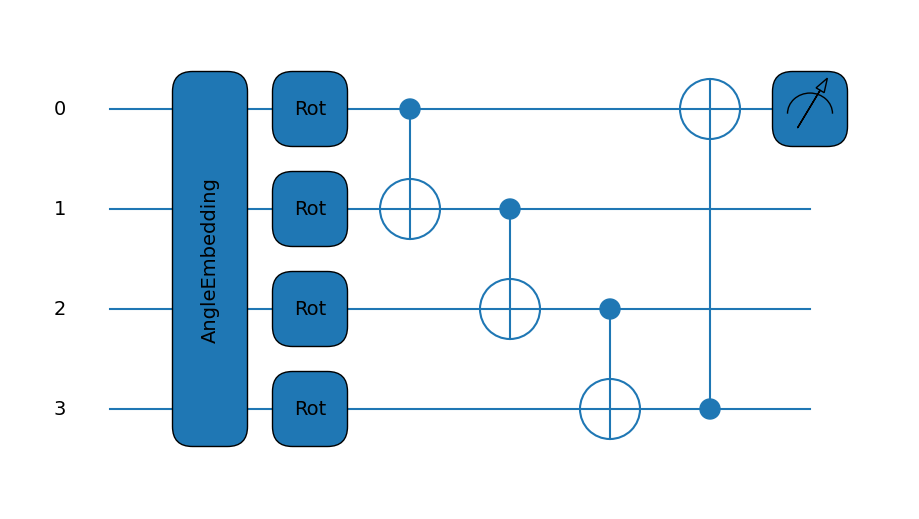

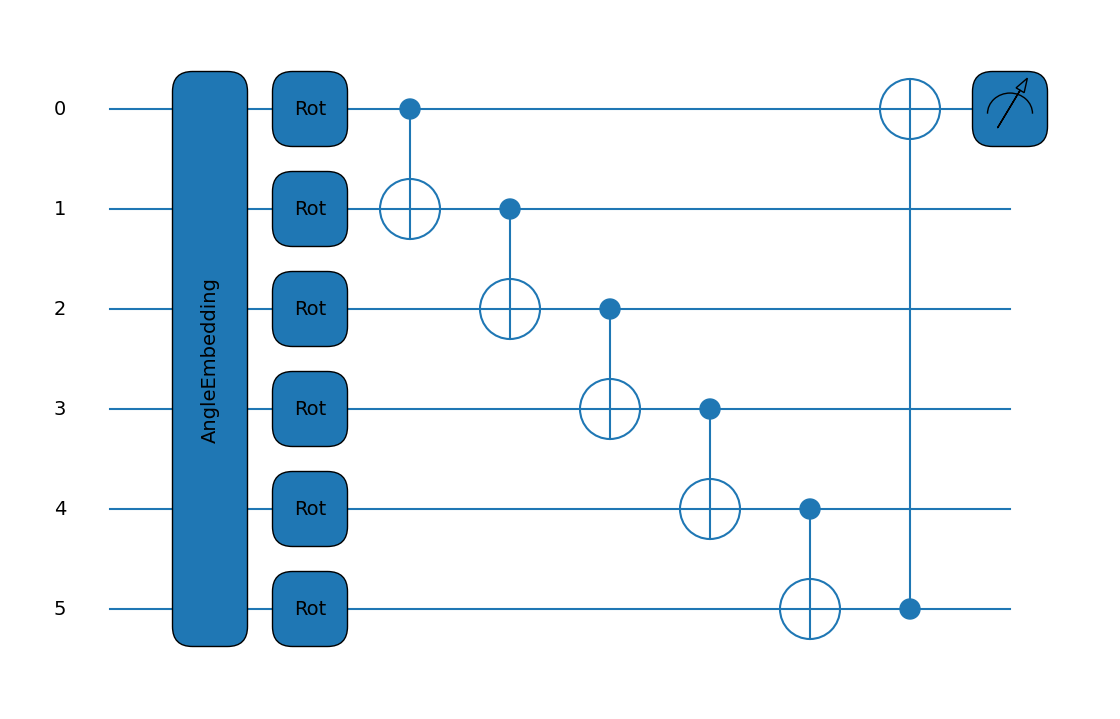

In [5]:
def Layered(*args):
    num_qubits, weights, features = args

    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:
        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

        for qubit in range(num_qubits):
            qml.CNOT(wires=[qubit, (qubit+1) % num_qubits])

    return qml.expval(qml.PauliZ(0))

calculate_depth(Layered)
draw_circuit_mpl(Layered, 4)
draw_circuit_mpl(Layered, 6)

#### [Pairwise Controlled Rotation Circuit](https://arxiv.org/pdf/1612.02806.pdf)

The pairwise controlled rotation circuit from the 2017 ***[Quantum Autoencoders for efficient compression of quantum data](https://arxiv.org/pdf/1612.02806.pdf)*** utilizes exactly the name: continuous pairs of controlled rotation gates where the control is a given qubit and the target all possible other qubits. Prefixed and suffixed with single qubit rotation gates, there is a comprehensive amount of entanglement between wires. This forms a sections of entanglement of each wire to its peers in the order of n sections of n-1 wires.

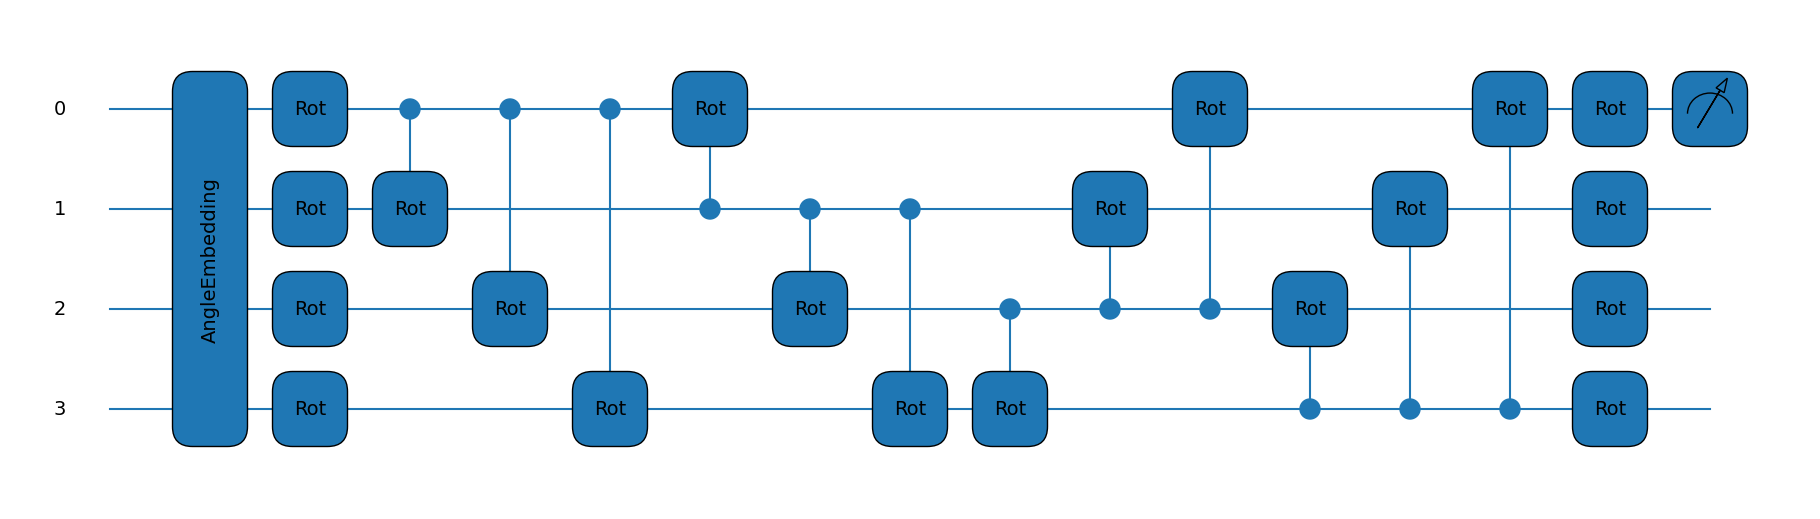

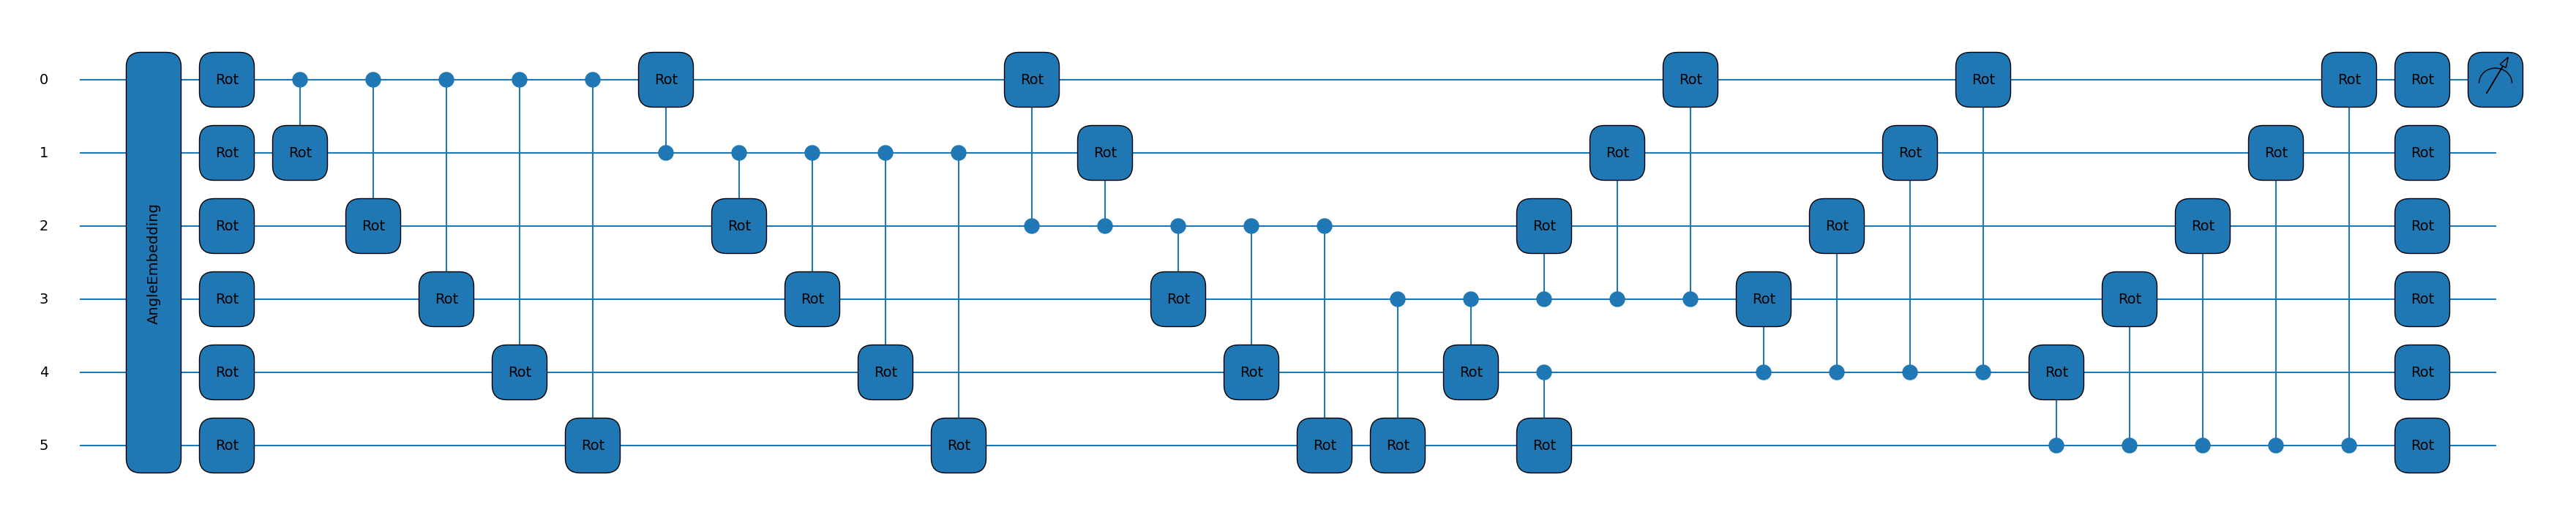

In [6]:
def PairwiseCRot(*args):
    num_qubits, weights, features = args

    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:

        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0],W[qubit, 1], W[qubit, 2], wires=qubit)

        for outer_qubit in range(num_qubits):

            valid_pairs = list(range(num_qubits))
            valid_pairs.remove(outer_qubit)

            if num_qubits / 2 <= outer_qubit:
                valid_pairs.reverse()

            for inner_qubit in valid_pairs:
                qml.CRot(W[outer_qubit,0], W[outer_qubit, 1], W[outer_qubit, 2], wires=[outer_qubit, inner_qubit])


        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

    return qml.expval(qml.PauliZ(0))

calculate_depth(PairwiseCRot)
draw_circuit_mpl(PairwiseCRot, 4)
draw_circuit_mpl(PairwiseCRot, 6)

#### [A and B Parameterization Circuit](https://pennylane.ai/qml/glossary/circuit_ansatz.html#a-parametrized-b-parametrized)
A novel AB parameterization circuit

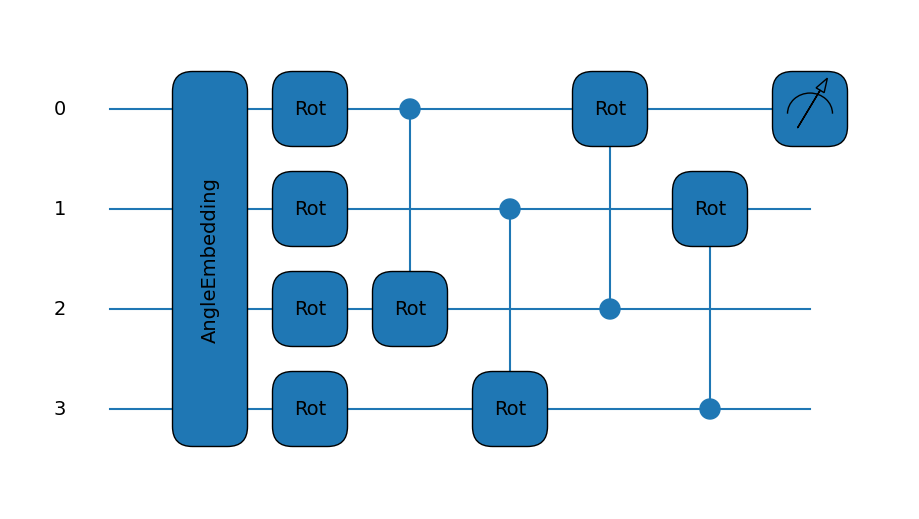

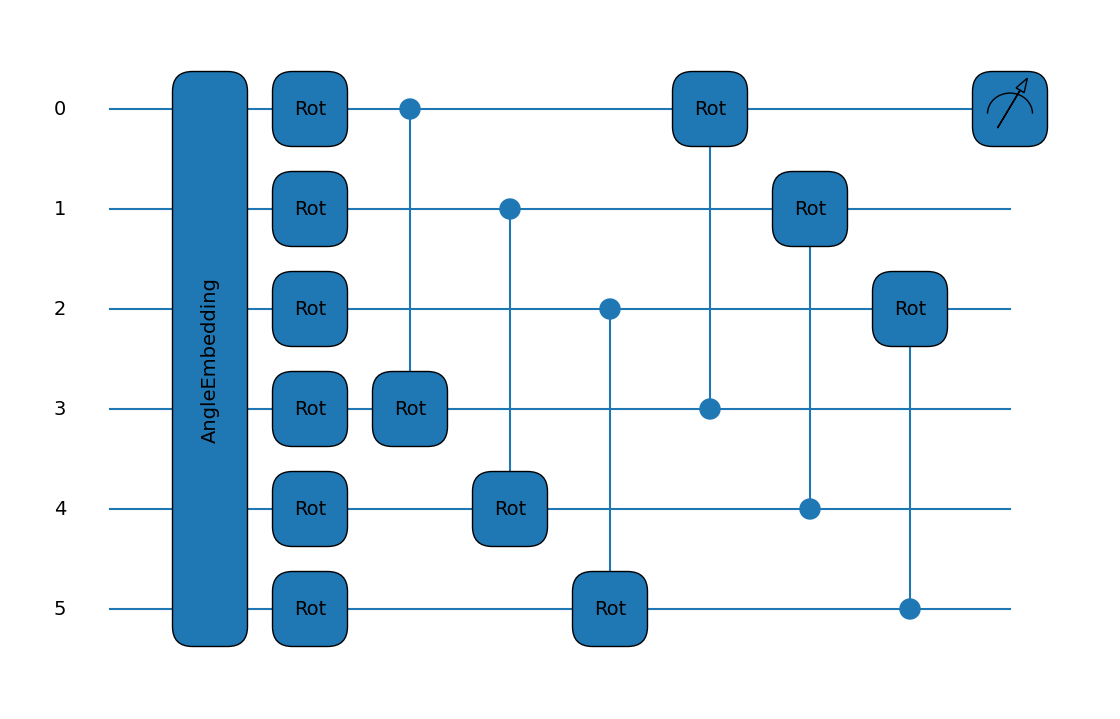

In [7]:
def ParameterizedAB(*args):
    num_qubits, weights, features = args
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")


    for W in weights:
        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0],W[qubit, 1], W[qubit, 2], wires=qubit)

        for qubit in range(num_qubits):
            qml.CRot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=[qubit, (num_qubits/2 + qubit) % num_qubits])

    return qml.expval(qml.PauliZ(0))

calculate_depth(ParameterizedAB)
draw_circuit_mpl(ParameterizedAB, 4)
draw_circuit_mpl(ParameterizedAB, 6)

#### [Strong Entanglement Circuit](https://arxiv.org/pdf/1804.00633.pdf)
Utilizing a generic model circuit architecture for strongly entangled wires, the blocks are parameterized in an A and B subsection similar to the AB parameterization. Utilizing a modulus function involving the range of the operations of specific gates, a greatly entangled circuit is generated. The paper goes in depth with optimizations of this generic strongly entangled AB parameterization ansatz circuit regarding global phases and phase gates. For the purposes of this study, the generic circuit architecture is being used with rotation gates as the single qubit gates and controlled not gates as the entanglement gates.

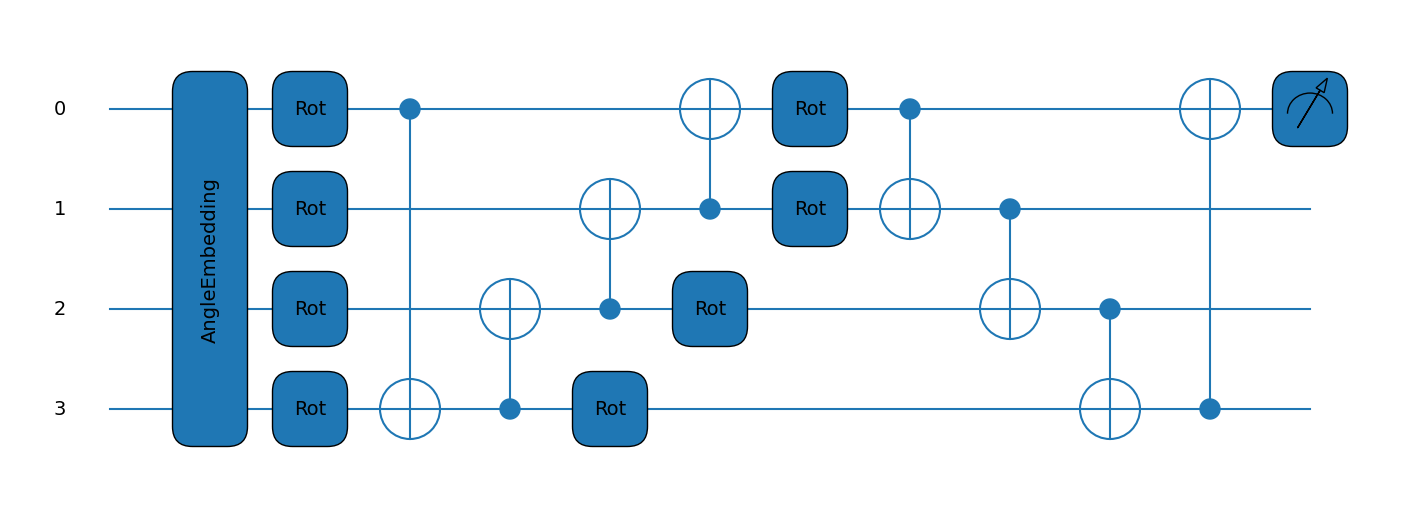

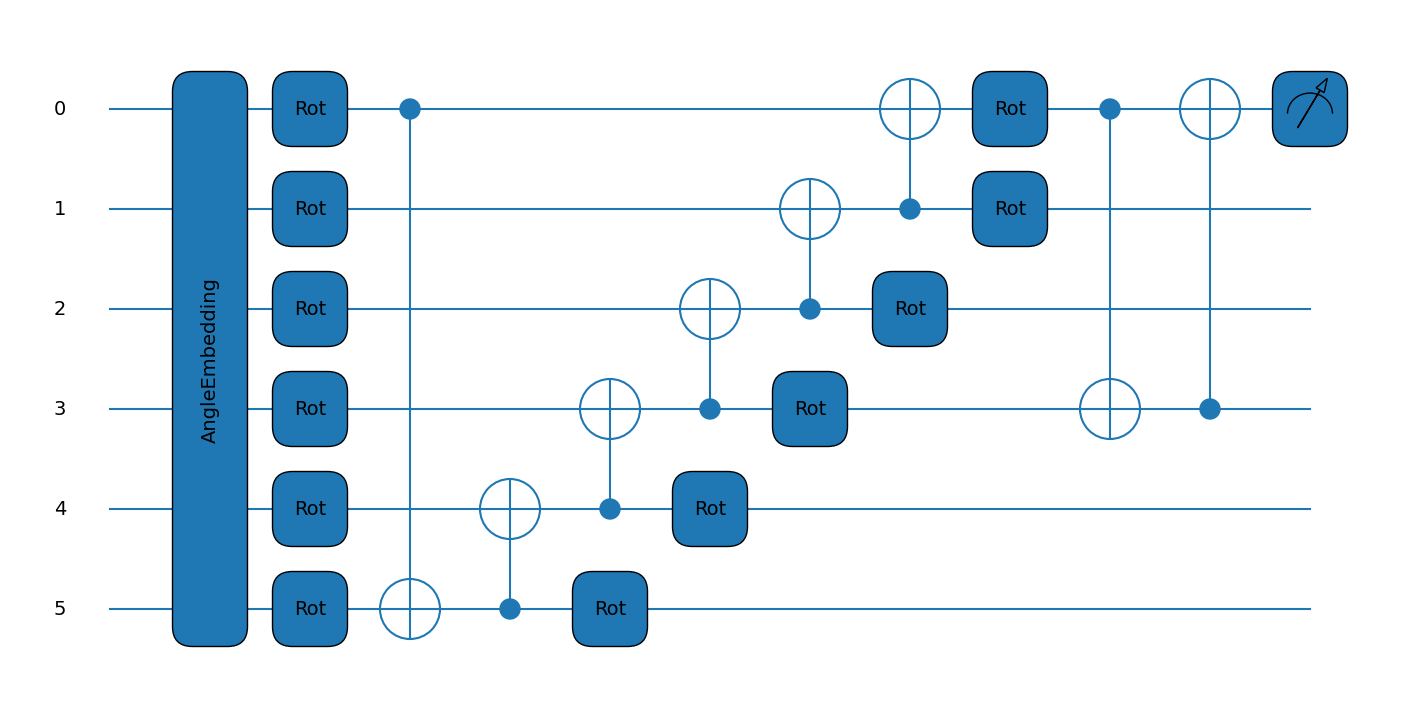

In [8]:
def StronglyEntangled(*args):
    num_qubits, weights, features = args
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:
        for r in [1, 3]:
            for qubit in range(num_qubits):
                qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

            for j in reversed(range(1, int(num_qubits / math.gcd(num_qubits, r))+1)):
                qubit_target = ((j * r) - r) % num_qubits
                qubit_control = (j * r) % num_qubits
                qml.CNOT(wires=[qubit_control, qubit_target])

    return qml.expval(qml.PauliZ(0))

calculate_depth(StronglyEntangled)
draw_circuit_mpl(StronglyEntangled, 4)
draw_circuit_mpl(StronglyEntangled, 6)

#### [Hardware Efficient Circuit](https://www.nature.com/articles/nature23879)


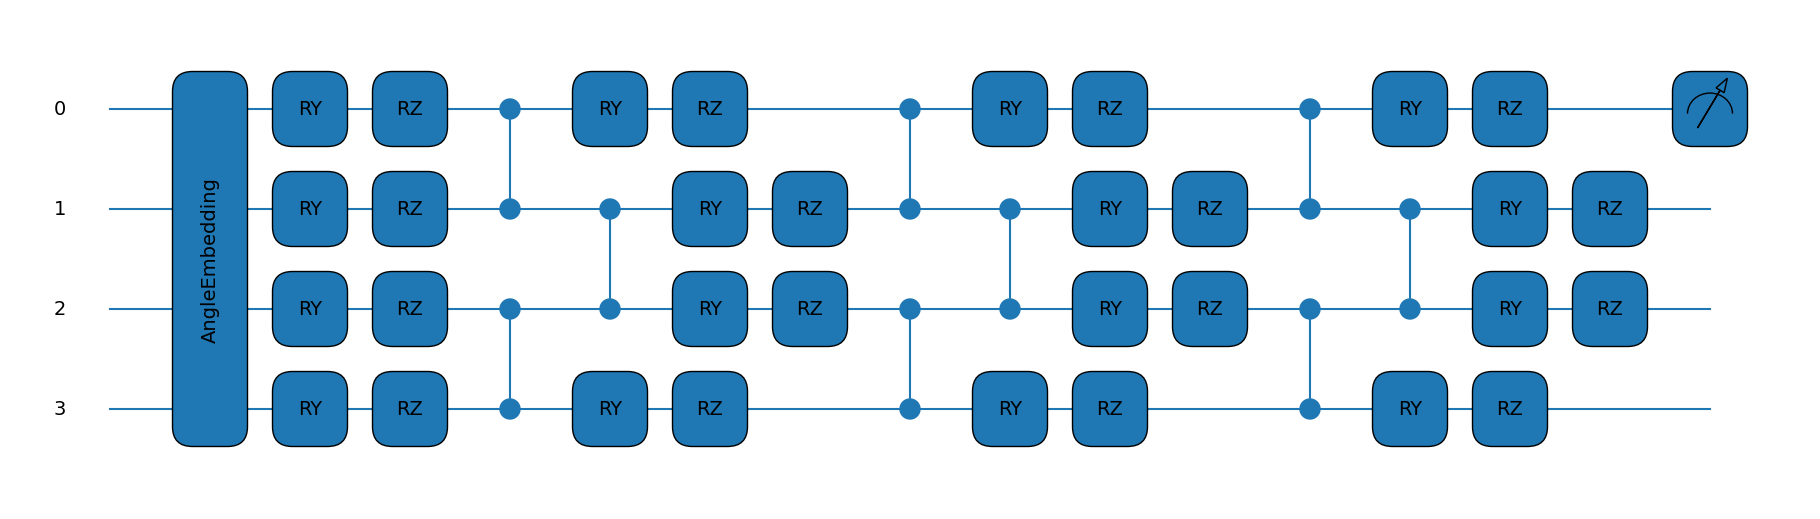

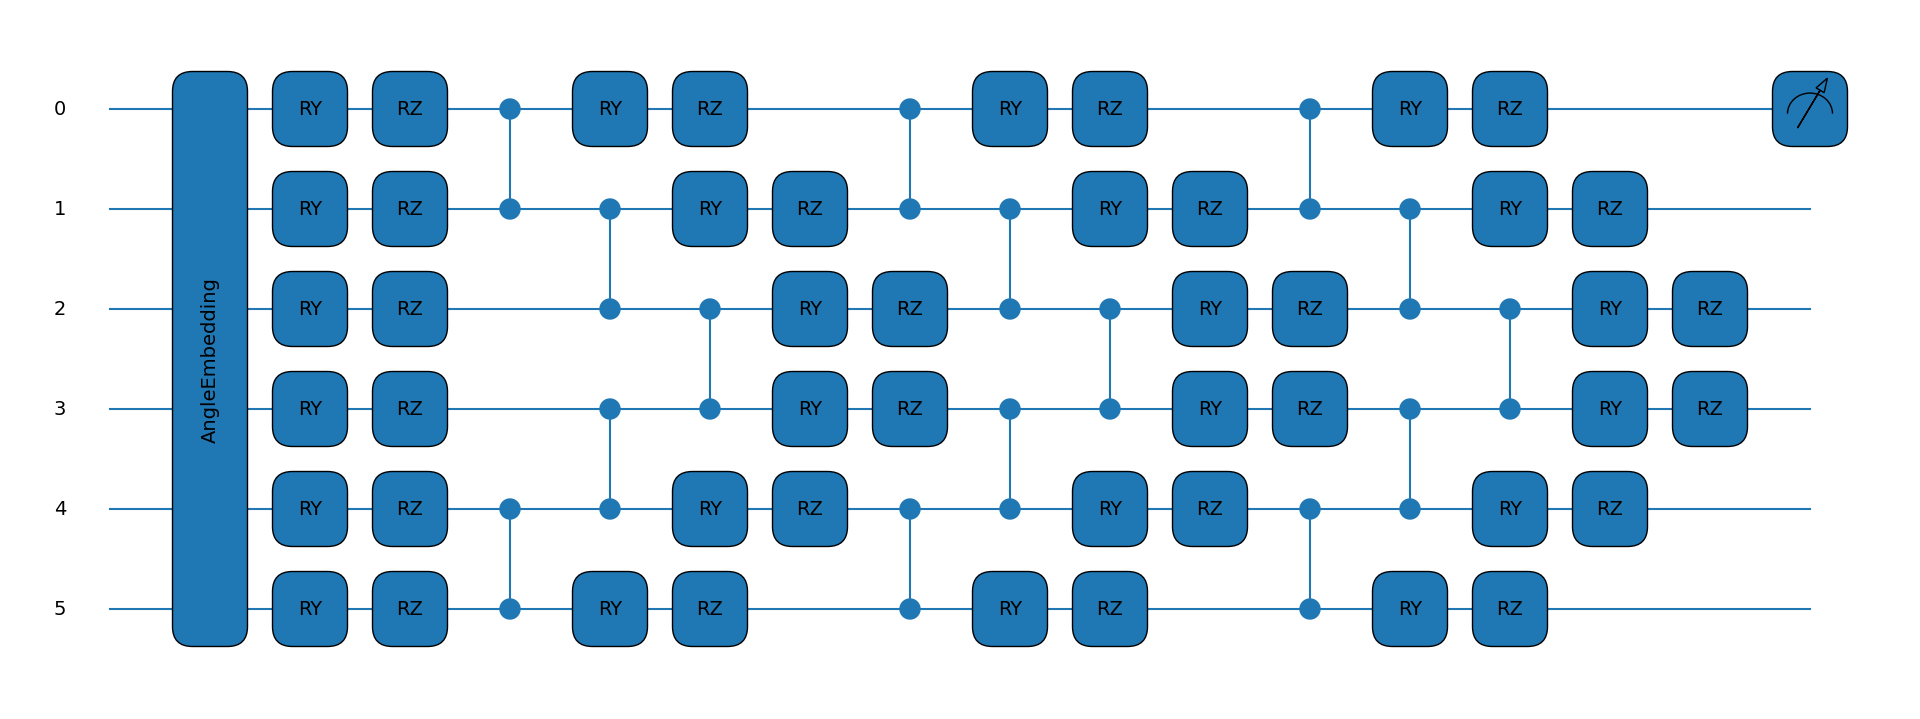

In [9]:
def HardwareEfficient(*args):
    num_qubits, weights, features = args
    depth = 3
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:

        for d in range(depth):
            for qubit in range(num_qubits):
                qml.RY(W[qubit, 0], wires=qubit)
                qml.RZ(W[qubit, 0], wires=qubit)

            for qubit in range(int(num_qubits/2)):
                p1 = [qubit, qubit+1]
                p2 = [num_qubits-qubit-1, num_qubits-qubit-2]
                qml.CZ(wires=p1)
                qml.CZ(wires=p2) if set(p1) != set(p2) else None

        for qubit in range(num_qubits):
            qml.RY(W[qubit, 0], wires=qubit)
            qml.RZ(W[qubit, 0], wires=qubit)

    return qml.expval(qml.PauliZ(0))

calculate_depth(HardwareEfficient)
draw_circuit_mpl(HardwareEfficient, 4)
draw_circuit_mpl(HardwareEfficient, 6)

### Data Generation, Parsing, and Preprocessing

In [10]:
# Simple Synthetic Data Generation Function from Qiskit Machine Learning Documentation.
def generate_synthetic_data(num_samples, num_features):
    X = algorithm_globals.random.normal(0, 0.5, size=(num_samples, num_features))
    y01 = 1 * (np.sum(X, axis=1) >= 0)
    y = 2 * y01 - 1    
    return X,y

In [11]:
def preprocess(df, samples, num_features):
    # Set the first unique target to -1, the second unique target to 1
    try:
        df.target = df.target.map(
            {df.target.unique()[1]: -1, df.target.unique()[2]: 1})
    except IndexError:
        df.target = df.target.map(
            {df.target.unique()[0]: -1, df.target.unique()[1]: 1})

    # Undersample datasets down to 100 samples
    try:
        df = pd.concat([
            df[(df.target == -1)].sample(n=samples, replace=False,
                                         random_state=rand.randint(0, 100)),
            df[(df.target == 1)].sample(n=samples, replace=False,
                                        random_state=rand.randint(0, 100))])
    # Otherwise take the sample as is
    except ValueError:
        pass
    # Remove any ternary or above targets
    finally:
        df = df[(df.target == -1) | (df.target == 1)]


    # Split data to features, labels
    # Min-Max normalize the features and represent as angles (2pi)
    X = np.array(df)[:, 0:num_features]
    features = 2 * np.pi * (X - np.min(X)) / (np.max(X) - np.min(X))
    labels = np.array(df)[:, -1]

    return features, labels


# Traditional Datasets
iris_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
banknote_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
transfusion_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data'
vertebral_column_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/vertebral_column.data'
seeds_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/seeds.data'
diabetes_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/diabetes.data'
water_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/water_potability.data'

# 4 Qubit Datasets
column_names = ['a0', 'a1', 'a2', 'a3', 'target']
iris_df = pd.read_csv(iris_path, names=column_names)
banknote_df = pd.read_csv(banknote_path, names=column_names)
transfusion_df = pd.read_csv(transfusion_path, names=column_names, skiprows=1)

# 6 Qubit Datasets
column_names = ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'target']
vertebral_column_df = pd.read_csv(vertebral_column_path, names=column_names)
seeds_df = pd.read_csv(seeds_path, names=column_names)

# Initial weights and biases for the datasets
init_bias = np.array(0.0, requires_grad=True)
init_weights_4d = 0.01 * np.random.randn(6, 4, 3, requires_grad=True)
init_weights_6d = 0.01 * np.random.randn(6, 6, 3, requires_grad=True)


In [12]:
# Perform preprocessing and initialize a dictionary of data, weights, biases
Q4_datasets = {
    'iris': (init_weights_4d, init_bias, *preprocess(iris_df, 50, 4)),
    'transfusion': (init_weights_4d, init_bias, *preprocess(transfusion_df, 50, 4)),
    'banknote': (init_weights_4d, init_bias, *preprocess(banknote_df, 50, 4)),
    'synth': (init_weights_4d, init_bias, *generate_synthetic_data(50, 4)),
}
Q6_datasets = {
    'vertebral_column': (init_weights_6d, init_bias, *preprocess(vertebral_column_df, 50, 6)),
    'seeds': (init_weights_6d, init_bias, *preprocess(seeds_df, 50, 6)),
    'synth': (init_weights_6d, init_bias, *generate_synthetic_data(50, 6)),
}

### Test Class and Results Class

In [13]:
class CurrentResults():
    def __init__(self):
        self.df = pd.DataFrame(columns=['optimizer', 'circuit', 'dataset', 'iteration', 'epoch', 'cost', 'train_acc', 'test_acc', 'trained_weights', 'untrained_weights', 'shape'])
        self.optimizer = self.circuit = self.iteration = self.dataset = self.epoch = self.cost = self.train_acc = self.test_acc = trained_weights = untrained_weights = shape = None

    def update(self, optimizer=None, circuit=None, iteration=None, dataset=None, epoch=None, cost=None, train_acc=None, test_acc=None, trained_weights=None, untrained_weights=None, shape=None):
        if optimizer is not None: self.optimizer = optimizer
        if circuit is not None: self.circuit = circuit
        if iteration is not None: self.iteration = iteration
        if dataset is not None: self.dataset = dataset
        if epoch is not None: self.epoch = epoch
        if cost is not None: self.cost = cost
        if train_acc is not None: self.train_acc = train_acc
        if test_acc is not None: self.test_acc = test_acc
        if trained_weights is not None: self.trained_weights = trained_weights
        if untrained_weights is not None: self.untrained_weights = untrained_weights
        if shape is not None: self.shape = shape

    def format_results(self):
        return {'optimizer':self.optimizer, 'circuit':self.circuit,'dataset':self.dataset, 'iteration':self.iteration, 'epoch':self.epoch, 'cost':self.cost, 'train_acc':self.train_acc, 'test_acc':self.test_acc, 'trained_weights': self.trained_weights, 'untrained_weights': self.untrained_weights, 'shape': self.shape}

    def write(self):
        epoch_results = self.format_results()
        self.df = self.df.append(epoch_results, ignore_index=True)

class ANSATZ_CIRCUIT_TEST():
    def __init__(self, ansatz_type, num_qubits, num_iterations):
        self.device = self.circuit = self.ansatz = self.curr = None
        self.num_iterations = num_iterations
        self.num_qubits = num_qubits
        self.generate_ansatz(ansatz_type)

    def generate_ansatz(self, ansatz_type):
        self.device = qml.device("default.qubit", wires=self.num_qubits + 1)
        self.circuit_func = ansatz_type
        self.circuit =  qml.QNode(self.circuit_func, self.device)

    def write_results(self):
        out_directory = 'results'

        if not os.path.exists(out_directory):
            os.mkdir(out_directory)

        out_path = os.path.join(out_directory, f'{self.curr.circuit}-{self.curr.optimizer}')

        self.curr.df.to_csv(f'{out_path}.csv', index=False)

    def execute(self, datasets):
        # Generate Data
        for optimizer in ['adam', 'nm', 'adagrad']:
            self.curr = CurrentResults()

            for dataset_name, dataset in datasets.items():

                for iteration in range(self.num_iterations):
                    self.curr.update(circuit=self.circuit.__name__, dataset=dataset_name, iteration=iteration)
                    print(f'{self.circuit.__name__} | {optimizer} | {dataset_name} | {iteration+1} of {self.num_iterations}')
                    train_classifier(dataset, optimizer, self)
                    self.device.reset()

            self.write_results()


## Execution of Tests

In [14]:
# This code is extremely intense. The data logged from running it was performed over 3 weeks across many computers. Leaving commented for your own sanity.

# for circuit in [Layered, ParameterizedAB, PairwiseCRot, StronglyEntangled, HardwareEfficient]:
#     test = ANSATZ_CIRCUIT_TEST(num_qubits=4,ansatz_type=circuit, num_iterations=3)
#     test.execute(datasets=Q4_datasets)

# for circuit in [Layered, ParameterizedAB, PairwiseCRot, StronglyEntangled, HardwareEfficient]:
#     test = ANSATZ_CIRCUIT_TEST(num_qubits=6,ansatz_type=circuit, num_iterations=3)
#     test.execute(datasets=Q6_datasets)

## Data Analysis

In [15]:
# Read in the saved CSVs and create a dictionary of the results of the form
# results
#        < | Qubit Number |
#                           < | Circuit_Name |
#                                              < |Optimizer Name | = Pandas Dataframe
csv_headers = []
results_path = os.path.join(os.getcwd(), 'results')
filenames = os.listdir(os.path.join(results_path, 'q4'))
results = collections.defaultdict(lambda : collections.defaultdict(dict))

for qubit_num in ['q4', 'q6']:
    for file_name in filenames:
        file_path = os.path.join(results_path, qubit_num, file_name)
        data_type = file_name.split('.csv')[0]
        circuit_type = data_type.split('-')[0]
        opt_type = data_type.split('-')[1]
        df = pd.read_csv(file_path)
        csv_headers = df.columns
        results[int(qubit_num[1])][circuit_type][opt_type] = pd.read_csv(file_path)

#### Calculating the Best Optimizer
This is done by greedily averaging the maxima test accuracies for each dataset of q4 and q6 of a given circuit-optimizer.
Then, each average is compared the best optimizer is again greedily selected by max accuracy, min cost, min epoch in that order.

In [16]:
optimizer_dict = collections.defaultdict(dict)

def calculate_best_optimizer(circuit):

    total_averages = pd.DataFrame(columns=csv_headers)
    header_printed = False

    for opt_type in ['adam', 'nm', 'adagrad']:

        best_epochs = pd.DataFrame(columns=csv_headers)

        for qubit_num in [4,6]:

            df = results[qubit_num][circuit.__name__][opt_type]

            for dataset in df['dataset'].unique():

                df_dataset = df[df['dataset'] == dataset]
                df_dataset = df_dataset[df_dataset['test_acc'] == df_dataset.max()['test_acc']]
                best_epochs = best_epochs.append(df_dataset)

        numeric_averages = best_epochs[['cost', 'train_acc', 'test_acc', 'epoch']].mean()
        numeric_averages['optimizer'] = opt_type
        total_averages = total_averages.append(numeric_averages, ignore_index=True)


    ideal_optimizer = total_averages[total_averages['test_acc'] == total_averages.max()['test_acc']]
    ideal_optimizer = ideal_optimizer[ideal_optimizer['cost'] == ideal_optimizer.min()['cost']]
    ideal_optimizer = ideal_optimizer[ideal_optimizer['epoch'] == ideal_optimizer.min()['epoch']]
    ideal_optimizer = ideal_optimizer.iloc[0]['optimizer']

    print(f'{circuit.__name__} - Averaged Maxima Accuracy and Minima Epoch, Cost')
    display(total_averages[['optimizer', 'cost', 'train_acc', 'test_acc', 'epoch']])
    print(f'\t{ideal_optimizer}\n')

    for qubit_num in [4,6]:
        optimizer_dict[qubit_num][circuit.__name__] = ideal_optimizer

calculate_best_optimizer(Layered)
calculate_best_optimizer(ParameterizedAB)
calculate_best_optimizer(PairwiseCRot)
calculate_best_optimizer(StronglyEntangled)
calculate_best_optimizer(HardwareEfficient)


Layered - Averaged Maxima Accuracy and Minima Epoch, Cost


,optimizer,cost,train_acc,test_acc,epoch
0,adam,0.658110,0.784852,0.949098,52.525862
1,nm,0.441540,0.874767,0.961122,50.132075
2,adagrad,0.508545,0.854368,0.908907,55.753846


	nm

ParameterizedAB - Averaged Maxima Accuracy and Minima Epoch, Cost


,optimizer,cost,train_acc,test_acc,epoch
0,adam,0.761135,0.685356,0.838515,53.724138
1,nm,0.671445,0.746667,0.926684,53.586207
2,adagrad,0.542960,0.799319,0.916311,57.340314


	nm

PairwiseCRot - Averaged Maxima Accuracy and Minima Epoch, Cost


,optimizer,cost,train_acc,test_acc,epoch
0,adam,0.411521,0.903061,0.960226,56.620000
1,nm,0.695095,0.784835,0.967516,54.983607
2,adagrad,0.458228,0.875382,0.974080,66.391304


	adagrad

StronglyEntangled - Averaged Maxima Accuracy and Minima Epoch, Cost


,optimizer,cost,train_acc,test_acc,epoch
0,adam,0.455404,0.923928,0.982924,52.427481
1,nm,0.418396,0.885783,0.987317,49.146341
2,adagrad,0.390913,0.910544,0.950920,52.347701


	nm

HardwareEfficient - Averaged Maxima Accuracy and Minima Epoch, Cost


,optimizer,cost,train_acc,test_acc,epoch
0,adam,0.462994,0.874551,0.992977,57.938931
1,nm,0.687014,0.847178,0.960123,55.240000
2,adagrad,0.699587,0.747791,0.889693,55.443609


	adam



#### Circuit Results Summary

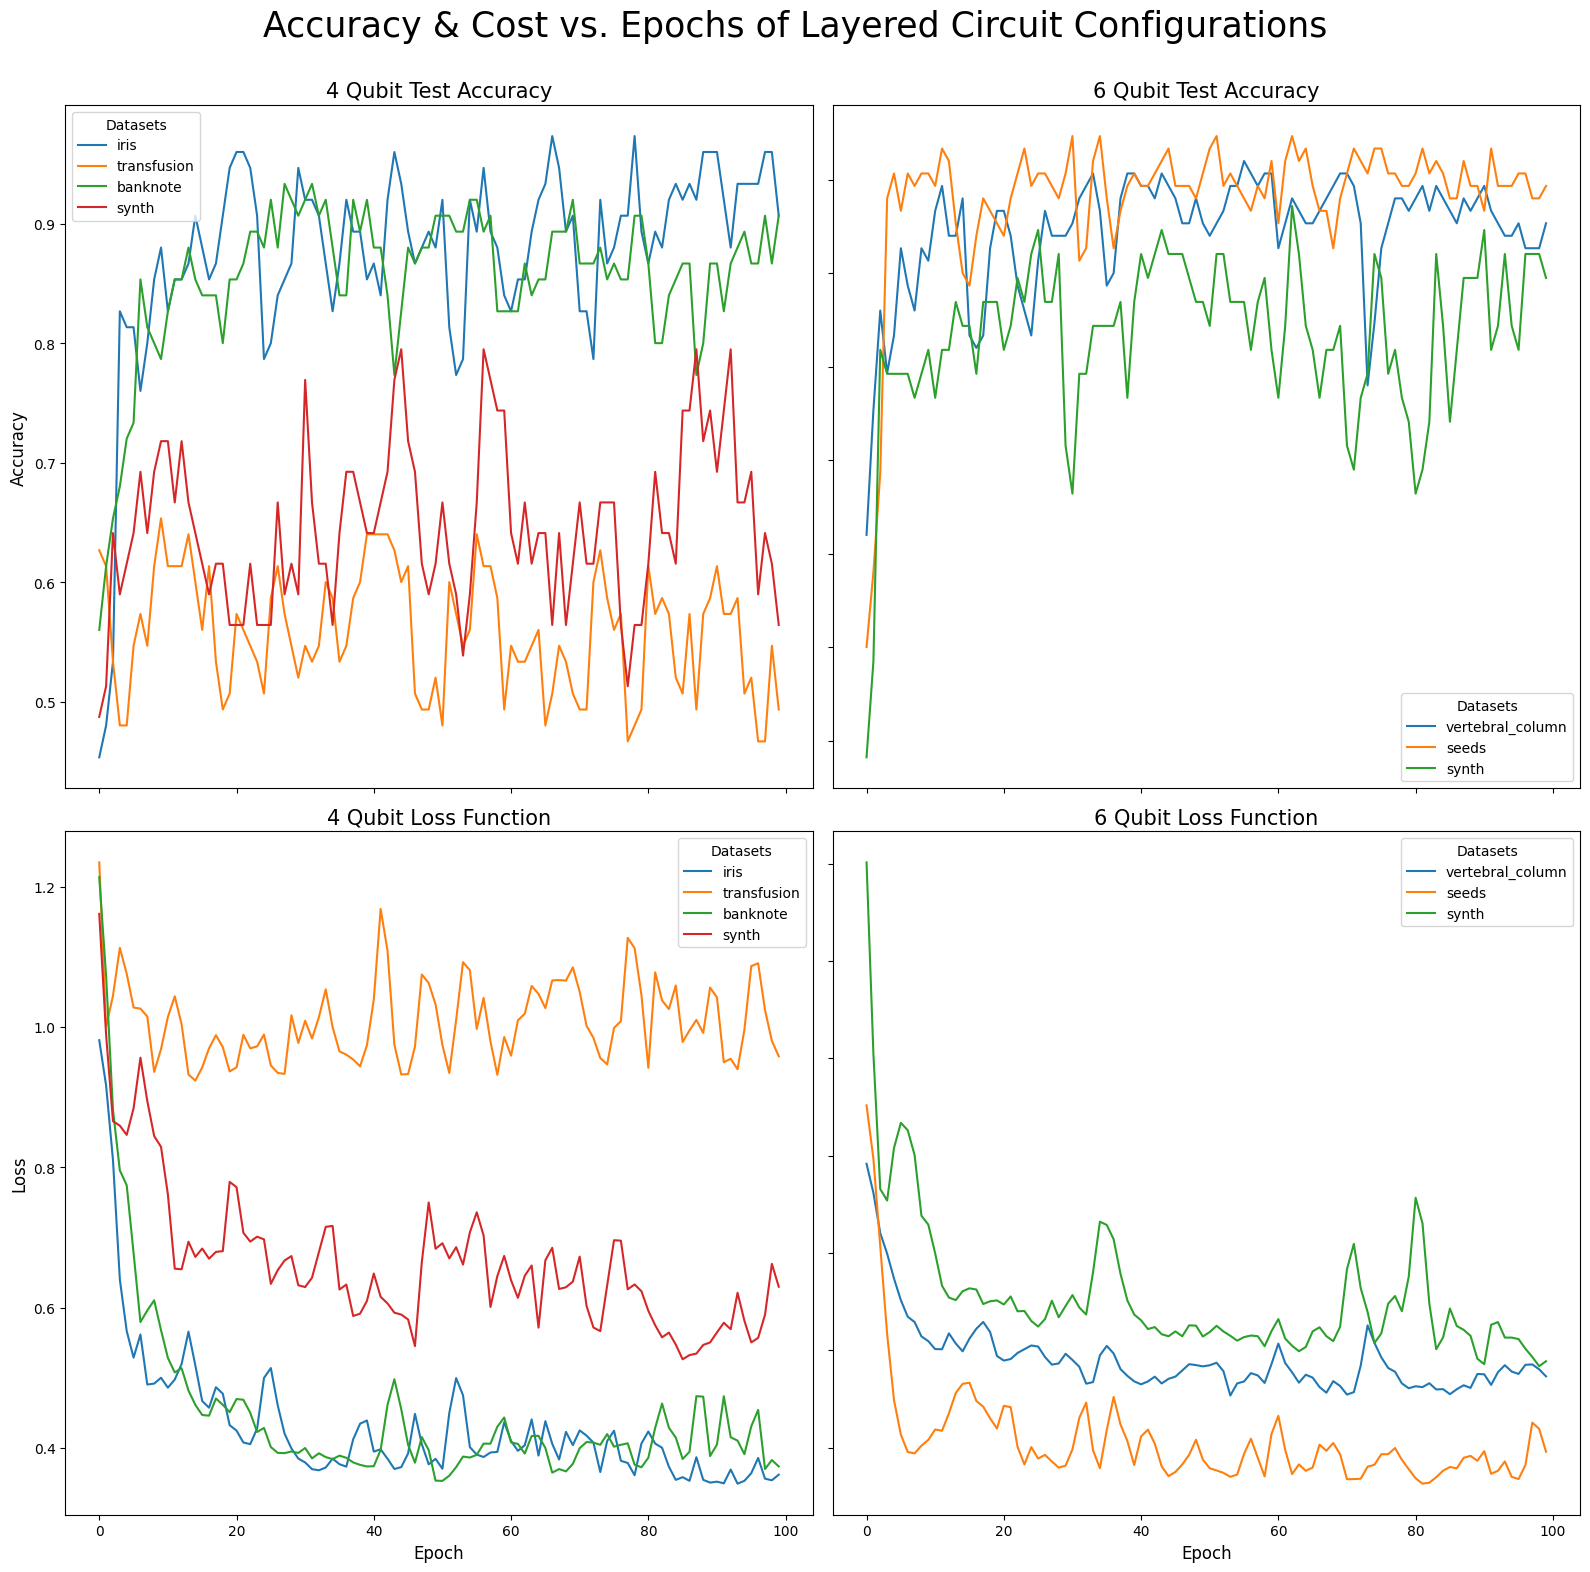

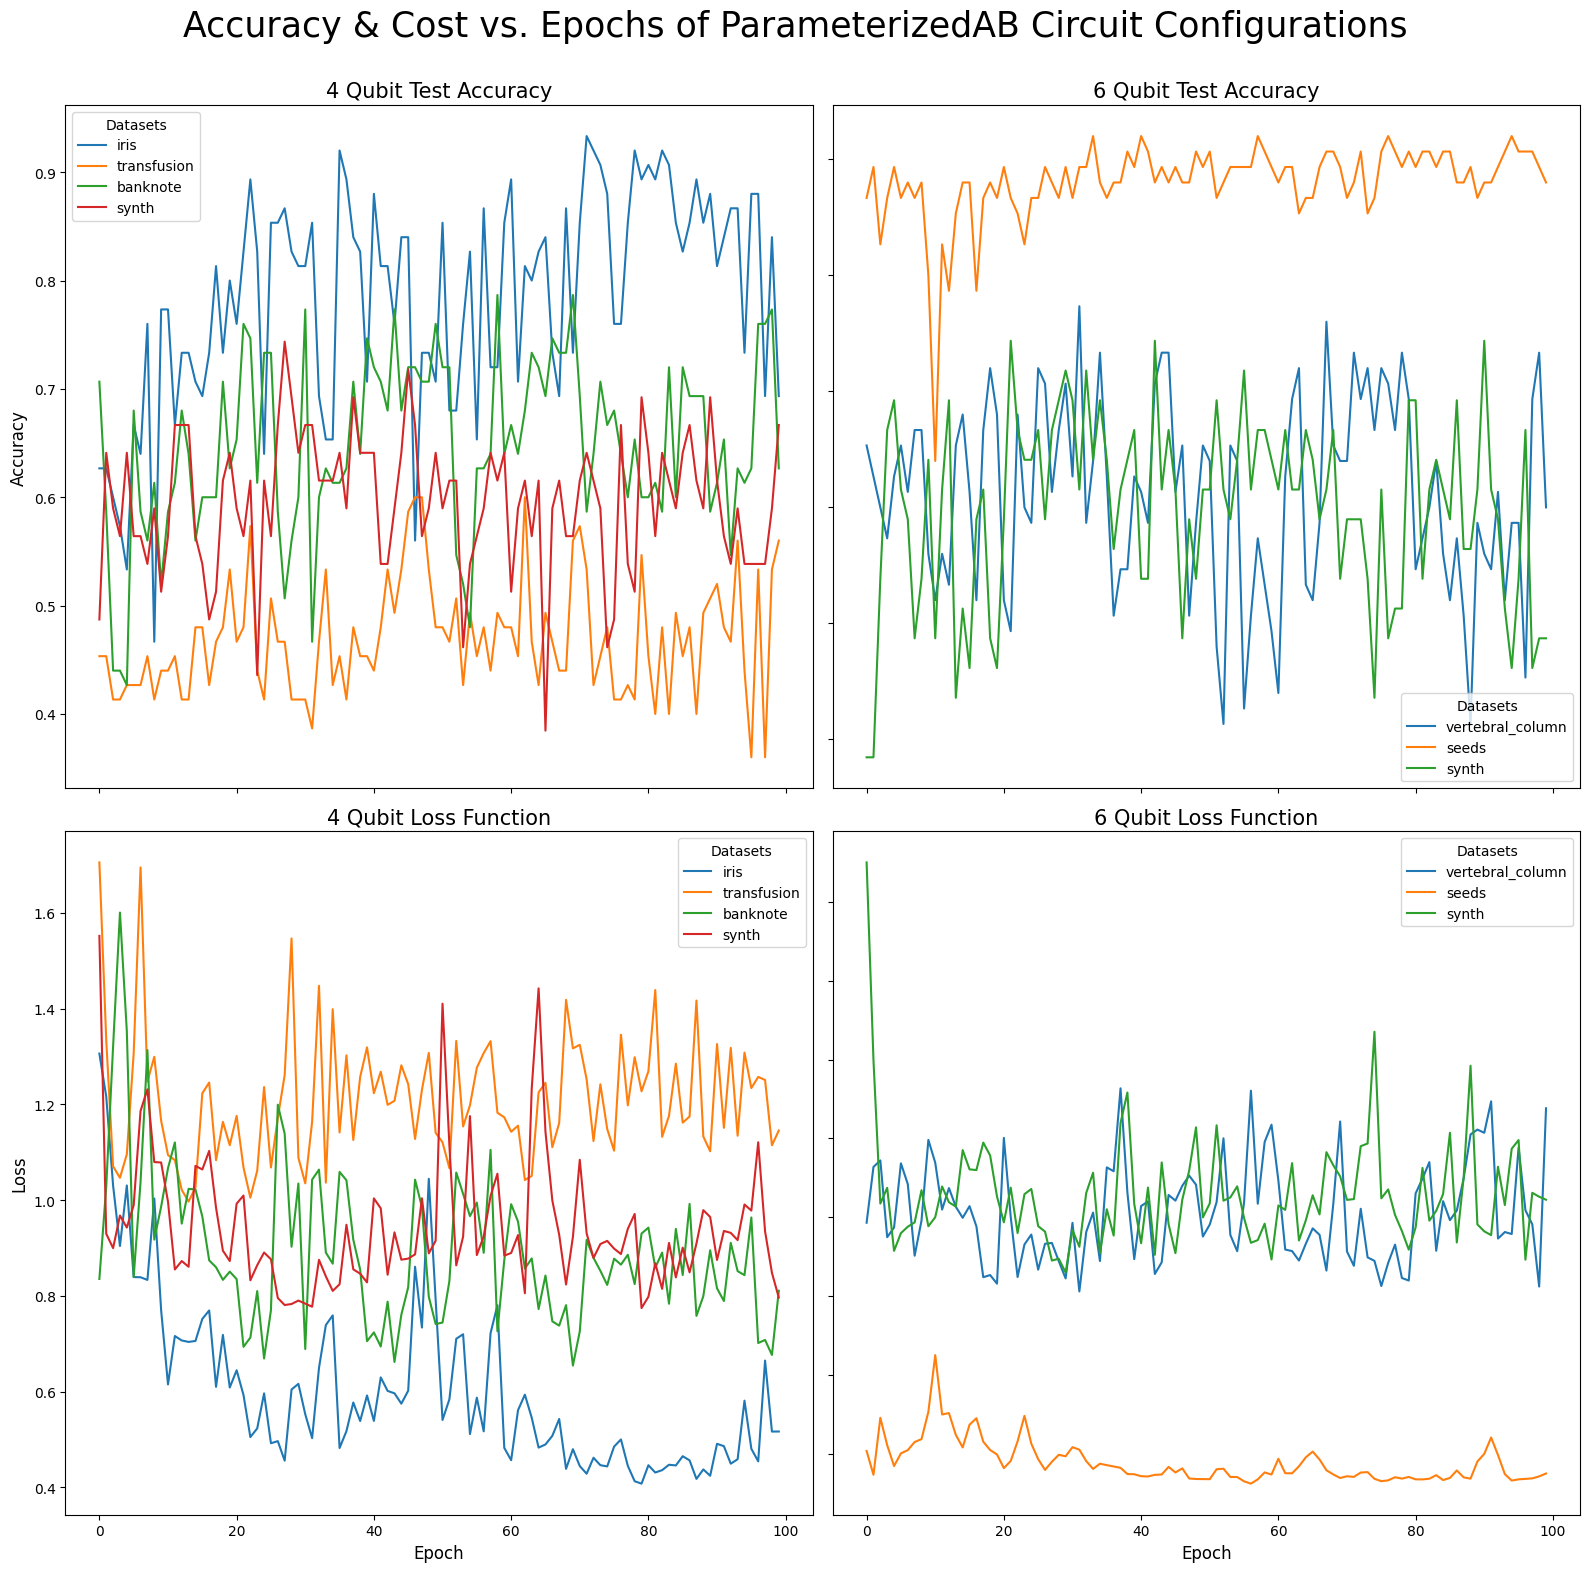

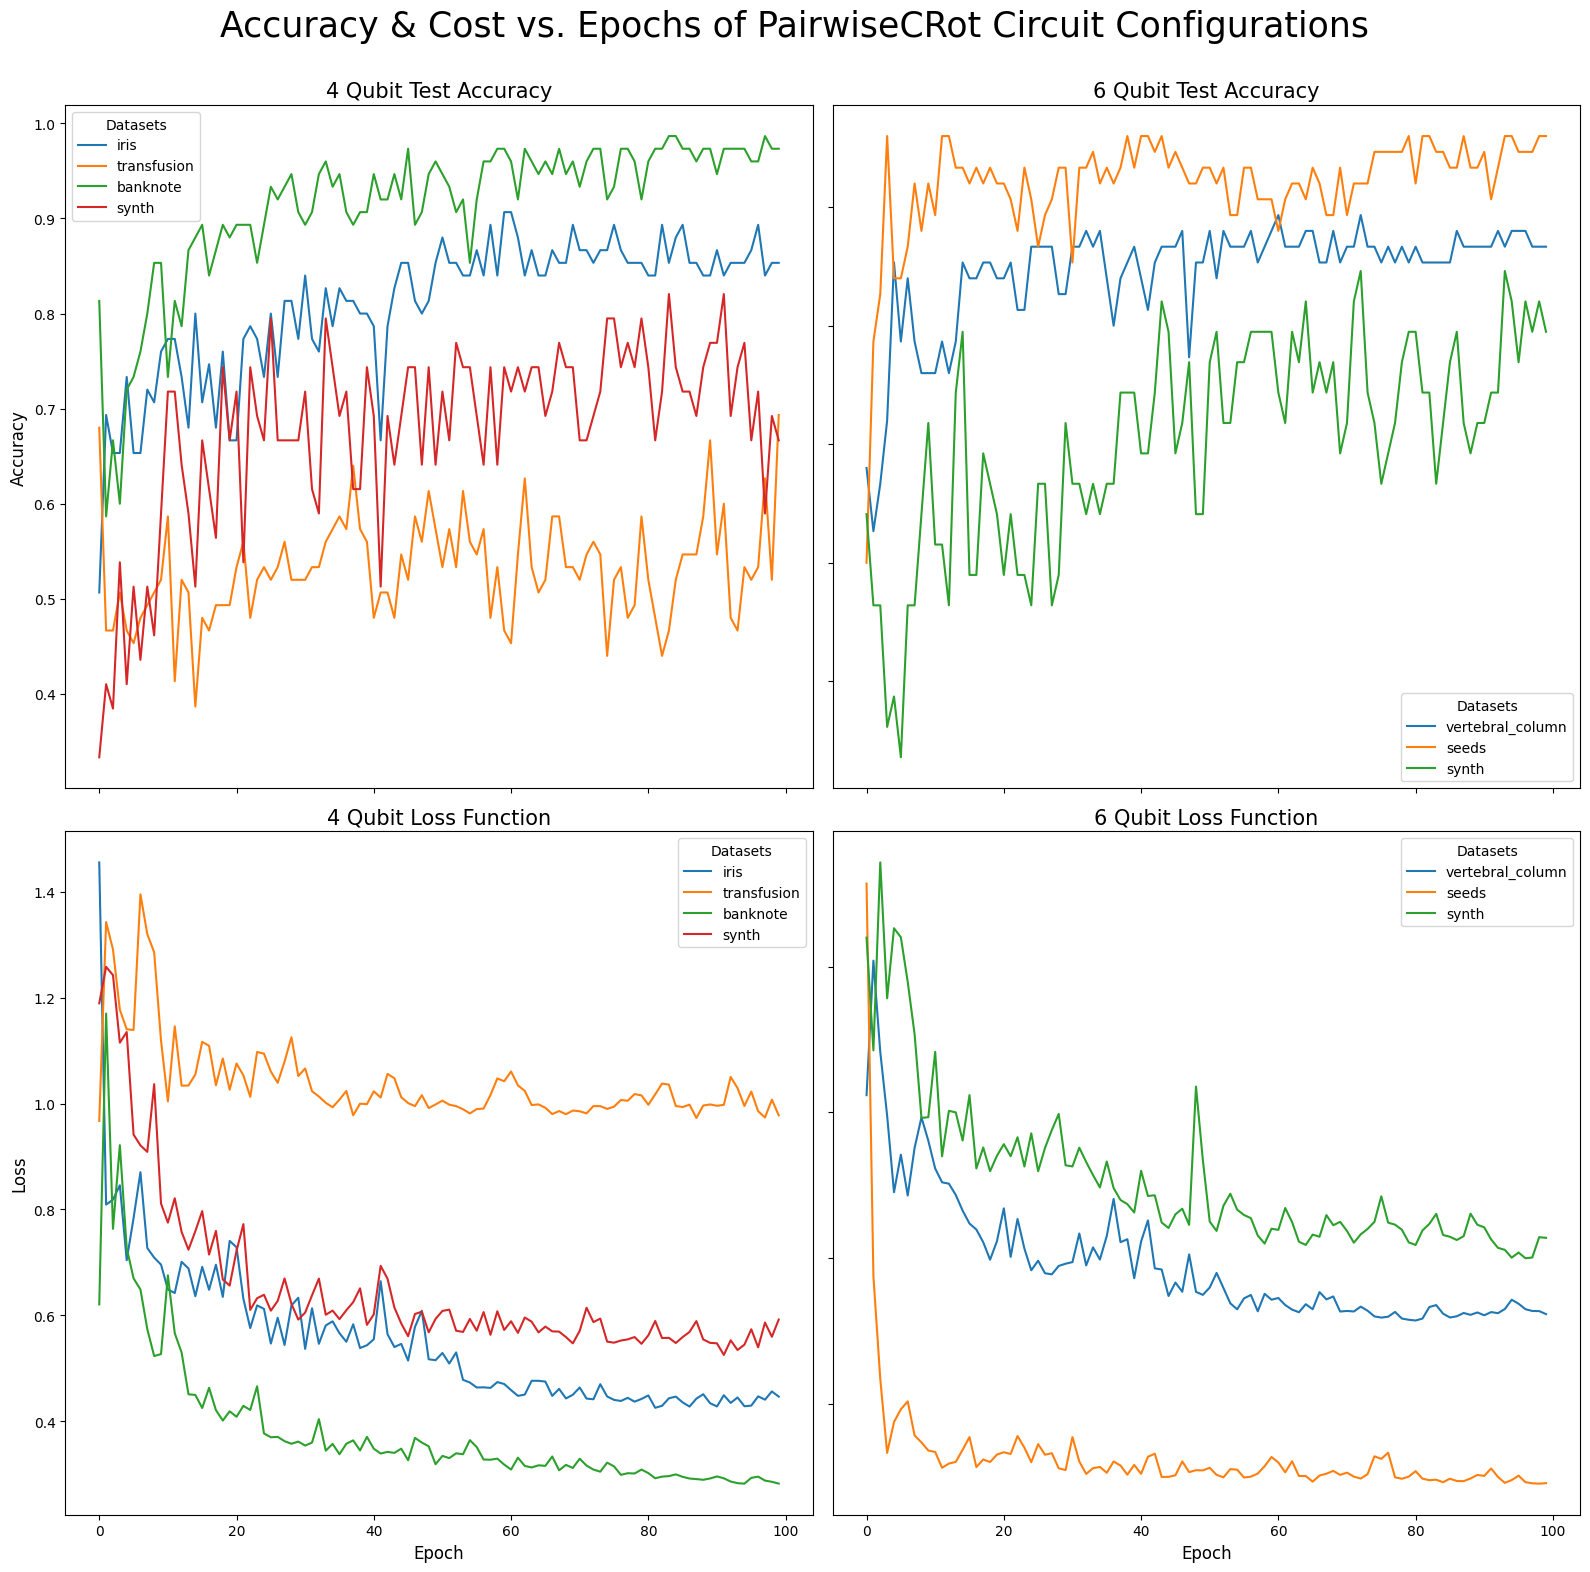

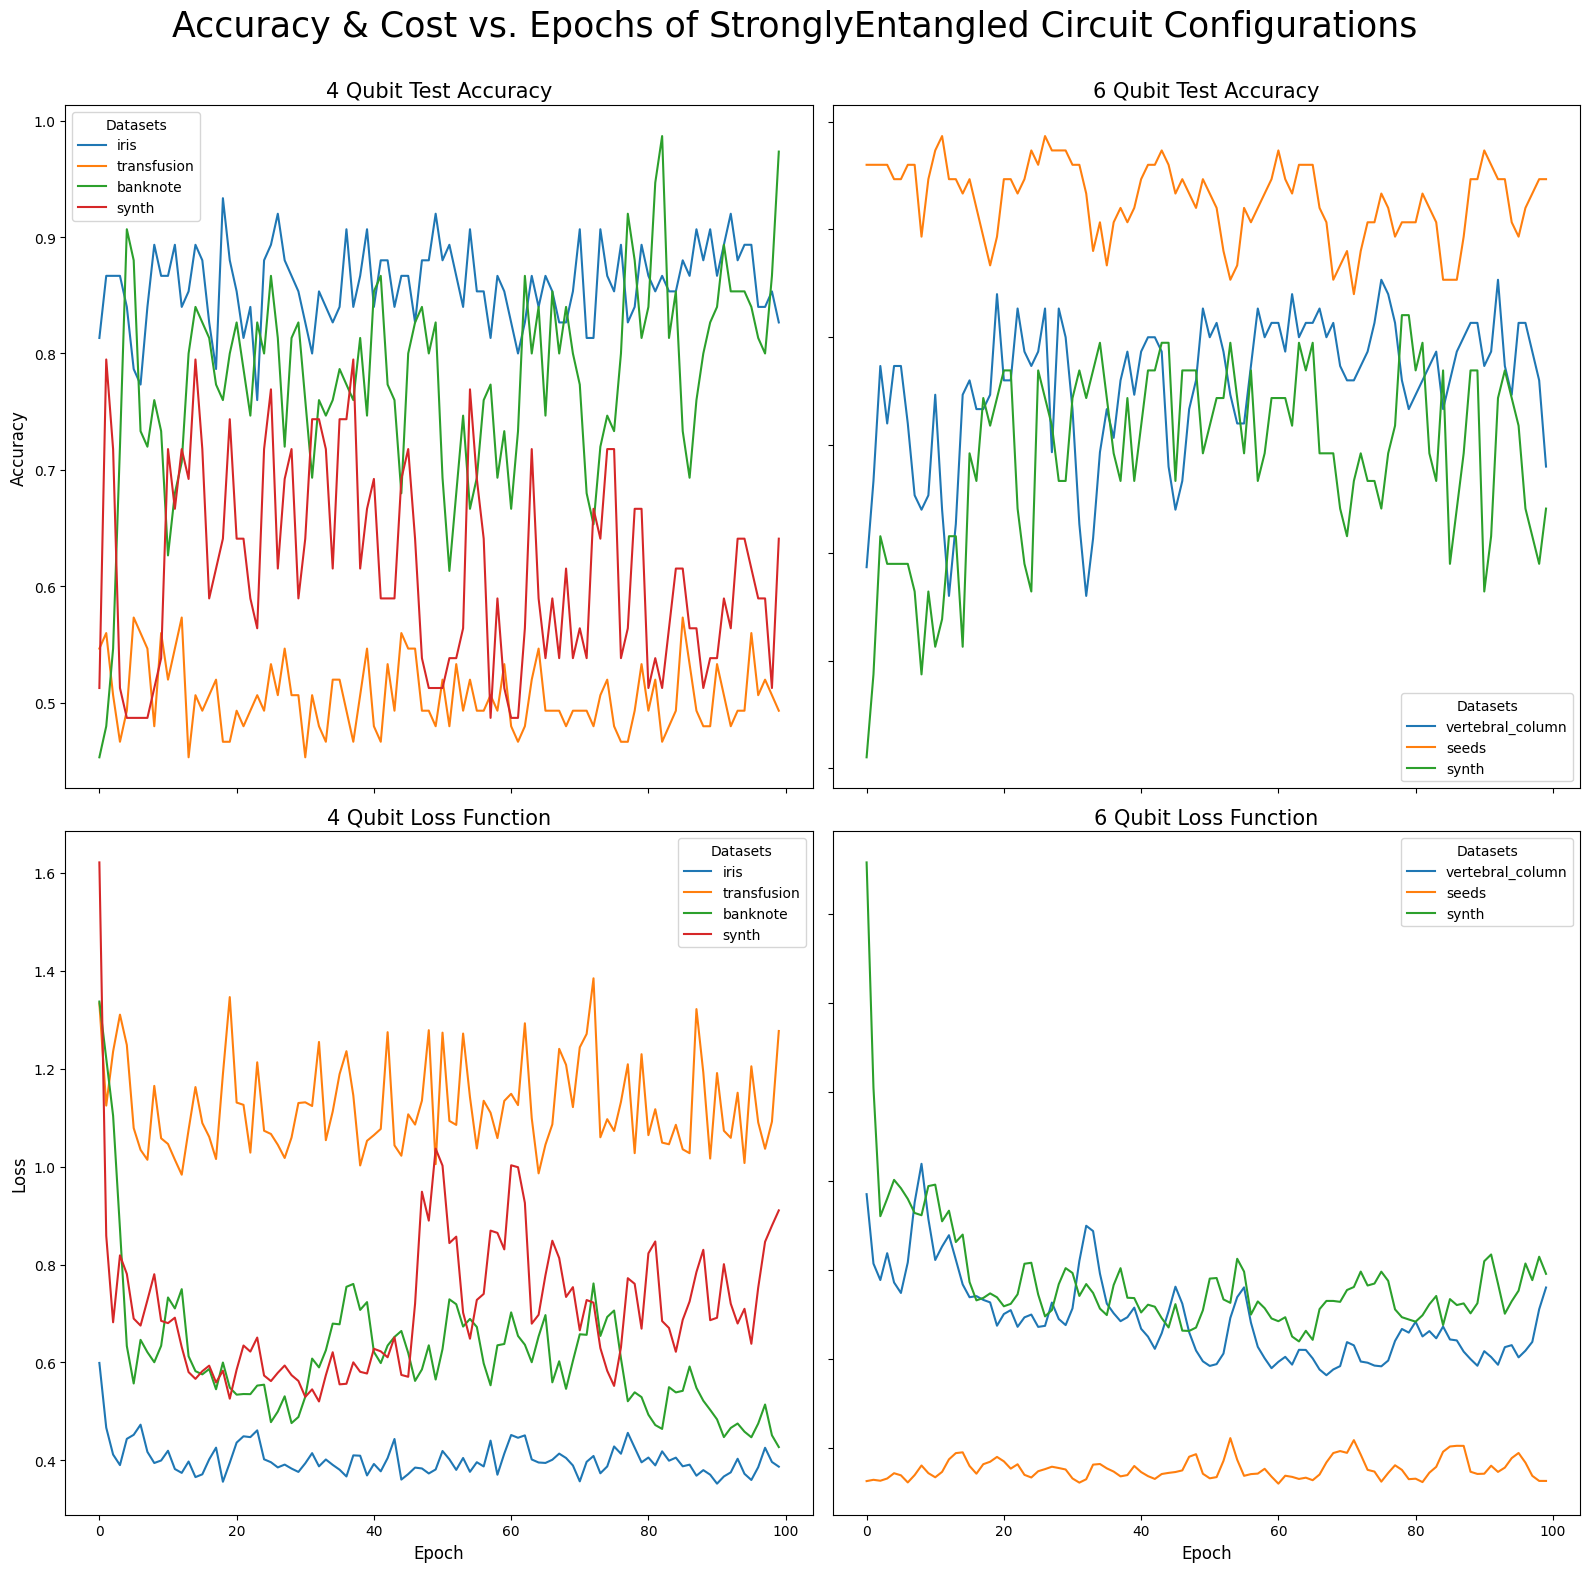

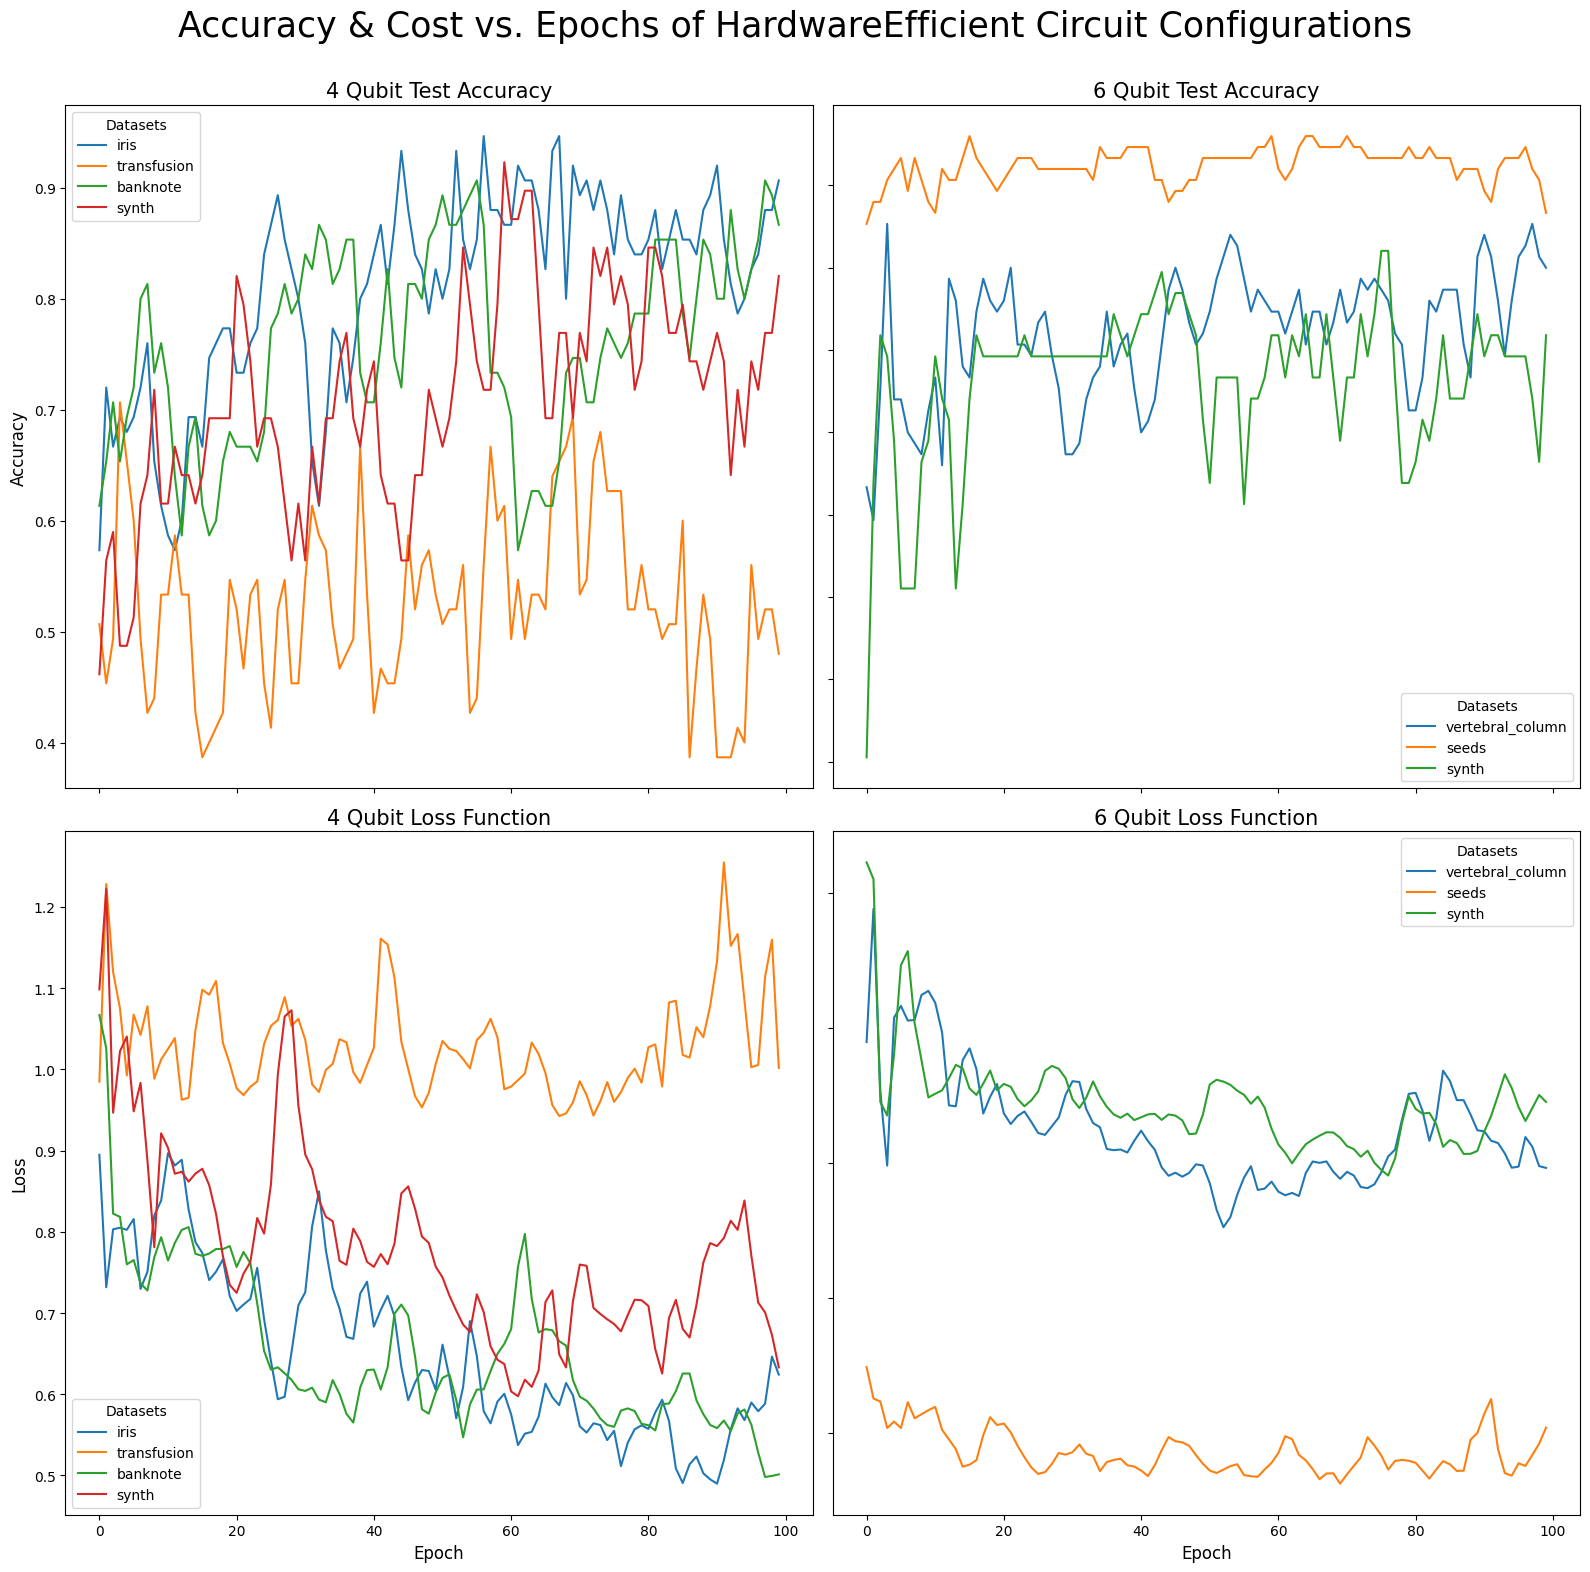

In [17]:
def calculate_epoch_avgs(df):
    epoch_averages = {}

    for dataset in df['dataset'].unique():

        epoch_averages[dataset] = pd.DataFrame(columns=df.columns)

        relevant_data = df[df['dataset'] == dataset]

        for epoch in range(100):
            avg_test_accuracy = relevant_data[relevant_data['epoch'] == epoch]['test_acc'].mean()
            avg_train_accuracy = relevant_data[relevant_data['epoch'] == epoch]['train_acc'].mean()
            avg_cost = relevant_data[relevant_data['epoch'] == epoch]['cost'].mean()

            new_instance = relevant_data[relevant_data['epoch'] == epoch].iloc[0]
            new_instance.loc['test_acc'] = avg_test_accuracy
            new_instance.loc['cost'] = avg_cost

            epoch_averages[dataset] = epoch_averages[dataset].append(new_instance, ignore_index=True)

    return epoch_averages

def graph_circuit_summary(circuit):

    opt_type = optimizer_dict[4][circuit.__name__]
    df_q4 = results[4][circuit.__name__][opt_type]
    df_q6 = results[6][circuit.__name__][opt_type]
    q4_averages = calculate_epoch_avgs(df_q4)
    q6_averages = calculate_epoch_avgs(df_q6)

    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,16))

    for dataset in df_q4['dataset'].unique():
        axs[0,0].plot(q4_averages[dataset]['epoch'], q4_averages[dataset]['test_acc'], label = dataset)
        axs[1,0].plot(q4_averages[dataset]['epoch'], q4_averages[dataset]['cost'], label = dataset)

    for dataset in df_q6['dataset'].unique():
        axs[0,1].plot(q6_averages[dataset]['epoch'], q6_averages[dataset]['test_acc'], label = dataset)
        axs[1,1].plot(q6_averages[dataset]['epoch'], q6_averages[dataset]['cost'], label = dataset)

    axs[0,0].set_xlabel('Epoch', fontsize=12)
    axs[0,0].set_ylabel('Accuracy', fontsize=12)
    axs[0,0].set_title('4 Qubit Test Accuracy', fontsize=15)
    axs[0,0].label_outer()
    axs[0,0].legend()
    axs[0,0].legend(title='Datasets')

    axs[0,1].set_xlabel('Epoch', fontsize=12)
    axs[0,1].set_ylabel('Accuracy', fontsize=12)
    axs[0,1].set_title('6 Qubit Test Accuracy', fontsize=15)
    axs[0,1].label_outer()
    axs[0,1].legend()
    axs[0,1].legend(title='Datasets')

    axs[1,0].set_xlabel('Epoch', fontsize=12)
    axs[1,0].set_ylabel('Loss', fontsize=12)
    axs[1,0].set_title('4 Qubit Loss Function', fontsize=15)
    axs[1,0].label_outer()
    axs[1,0].legend()
    axs[1,0].legend(title='Datasets')

    axs[1,1].set_xlabel('Epoch', fontsize=12)
    axs[1,1].set_ylabel('Loss', fontsize=12)
    axs[1,1].set_title('6 Qubit Loss Function', fontsize=15)
    axs[1,1].label_outer()
    axs[1,1].legend(title='Datasets')

    fig.suptitle(f'Accuracy & Cost vs. Epochs of {circuit.__name__} Circuit Configurations', fontsize=25)
    fig.tight_layout()
    plt.subplots_adjust(top=.92)


graph_circuit_summary(Layered)
graph_circuit_summary(ParameterizedAB)
graph_circuit_summary(PairwiseCRot)
graph_circuit_summary(StronglyEntangled)
graph_circuit_summary(HardwareEfficient)

#### Extracting Best Trained Models from the Iterations

In [18]:
best_models = collections.defaultdict(dict)


# Create a dictionary of dataframes of the best trained models of the qubit-num/circuit for each dataset, each iteration

for qubit_num in results.keys():
    for circuit in results[qubit_num].keys():

        opt_type = optimizer_dict[qubit_num][circuit]
        df = results[qubit_num][circuit][opt_type]
        dfs_dataset = [df[df['dataset'] == unique]
                       for unique in df['dataset'].unique()]
        best_models[qubit_num][circuit] = pd.DataFrame(columns=csv_headers)

        for df in dfs_dataset:

            for iteration in df['iteration'].unique():

                iteration_df = df[df['iteration'] == iteration]

                maxima = iteration_df['test_acc'].max()
                max_df = iteration_df[iteration_df['test_acc'] == maxima]
                minima = max_df['cost'].min()
                best_df = max_df[max_df['cost'] == minima].iloc[0]

                best_models[qubit_num][circuit] = best_models[qubit_num][circuit].append(
                    best_df, ignore_index=True)
                best_models[qubit_num][circuit]['epoch'] = best_models[qubit_num][circuit]['epoch'].astype(
                    int)


q4_results_table = q6_results_table = pd.DataFrame(columns=['Circuit', 'Mean Epoch', 'SD Epoch', 'Mean Accuracy', 'SD Accuracy', 'Mean Cost', 'SD Cost'])
ttest_table = pd.DataFrame(columns=['Circuit', 'Epoch t-test statistic', 'Epoch t-test P-Val'])

for circuit in best_models[4].keys():

    statistics = best_models[4][circuit].describe()
    row = {
        'Circuit' : circuit,
        'Mean Epoch': statistics['epoch']['mean'],
        'SD Epoch' : statistics['epoch']['std'],
        'Mean Accuracy': statistics['test_acc']['mean'],
        'SD Accuracy': statistics['test_acc']['std'],
        'Mean Cost' : statistics['cost']['mean'],
        'SD Cost' : statistics['cost']['std']
    }
    q4_results_table = q4_results_table.append(row, ignore_index=True)

for circuit in best_models[6].keys():
    statistics = best_models[6][circuit].describe()
    row = {
        'Circuit' : circuit,
        'Mean Epoch': statistics['epoch']['mean'],
        'SD Epoch' : statistics['epoch']['std'],
        'Mean Accuracy': statistics['test_acc']['mean'],
        'SD Accuracy': statistics['test_acc']['std'],
        'Mean Cost' : statistics['cost']['mean'],
        'SD Cost' : statistics['cost']['std']
    }
    q6_results_table = q6_results_table.append(row, ignore_index=True)

print('4 Qubit Summary by Circuit')
display(q4_results_table)
print('6 Qubit Summary by Circuit')
display(q6_results_table)


4 Qubit Summary by Circuit


,Circuit,Mean Epoch,SD Epoch,Mean Accuracy,SD Accuracy,Mean Cost,SD Cost
0,PairwiseCRot,79.750000,19.845425,0.891026,0.117499,0.557949,0.266180
1,ParameterizedAB,58.166667,35.342052,0.848462,0.123838,0.699036,0.254049
2,HardwareEfficient,69.500000,19.251918,0.926923,0.093144,0.625999,0.204743
3,Layered,73.333333,21.253164,0.877949,0.123324,0.556086,0.266875
4,StronglyEntangled,45.750000,27.755835,0.880769,0.145663,0.557056,0.267761


6 Qubit Summary by Circuit


,Circuit,Mean Epoch,SD Epoch,Mean Accuracy,SD Accuracy,Mean Cost,SD Cost
0,PairwiseCRot,86.111111,10.600052,0.917265,0.068084,0.473728,0.148823
1,ParameterizedAB,49.333333,29.073184,0.890256,0.076738,0.657680,0.246975
2,HardwareEfficient,62.666667,21.897488,0.917265,0.083154,0.610310,0.224421
3,Layered,66.888889,26.184177,0.942906,0.051879,0.490211,0.110353
4,StronglyEntangled,62.444444,23.670188,0.934701,0.064189,0.528106,0.160151


### Comparison of Circuit Depths

In [45]:

depth_models = {}
depth_results_table = pd.DataFrame()

# Initialize dict of depths
for qubit_num in circuit_depths.keys():
    for circuit in circuit_depths[qubit_num]:
        depth_val = circuit_depths[qubit_num][circuit]
        depth_models[depth_val] = pd.DataFrame()

# Populate dict
for qubit_num in best_models.keys():
    for circuit in best_models[qubit_num].keys():
        df = best_models[qubit_num][circuit]
        depth_val = circuit_depths[qubit_num][circuit]
        depth_models[depth_val] = pd.concat([depth_models[depth_val], df], ignore_index=True)


for depth in depth_models.keys():
    statistics = depth_models[depth].describe()
    row = {
        'Depth': depth,
        'Circuits':'',
        'Mean Epoch': statistics['epoch']['mean'],
        'SD Epoch' : statistics['epoch']['std'],
        'Mean Accuracy': statistics['test_acc']['mean'],
        'SD Accuracy': statistics['test_acc']['std'],
        'Mean Cost' : statistics['cost']['mean'],
        'SD Cost' : statistics['cost']['std']
    }
    depth_results_table = depth_results_table.append(row, ignore_index=True)

display(depth_results_table.sort_values(by=['Depth']))

,Depth,Circuits,Mean Epoch,SD Epoch,Mean Accuracy,SD Accuracy,Mean Cost,SD Cost
2,4,,54.380952,32.328743,0.866374,0.106016,0.681312,0.245634
0,6,,73.333333,21.253164,0.877949,0.123324,0.556086,0.266875
4,8,,66.888889,26.184177,0.942906,0.051879,0.490211,0.110353
3,11,,52.904762,26.823320,0.903883,0.118599,0.544649,0.223400
1,15,,74.625000,19.824913,0.908974,0.105301,0.591974,0.234823
6,16,,62.666667,21.897488,0.917265,0.083154,0.610310,0.224421
5,31,,86.111111,10.600052,0.917265,0.068084,0.473728,0.148823


In [53]:
epoch_data = pd.DataFrame()
cost_data = pd.DataFrame()
acc_data = pd.DataFrame()


for depth in depth_models.keys():
    epoch_data[depth] = depth_models[depth]['epoch']
    cost_data[depth] = depth_models[depth]['cost']
    acc_data[depth] = depth_models[depth]['test_acc']

epoch_data = epoch_data.reindex(sorted(epoch_data.columns), axis=1)
cost_data = cost_data.reindex(sorted(cost_data.columns), axis=1)
acc_data = acc_data.reindex(sorted(acc_data.columns), axis=1)

epoch_cov_matrix = pd.DataFrame.cov(epoch_data)
cost_cov_matrix = pd.DataFrame.cov(cost_data)
acc_cov_matrix = pd.DataFrame.cov(acc_data)

# Print Covariance Matrix
print('Epoch Covariance Matrix')
display(epoch_cov_matrix)

print('Cost Covariance Matrix')
display(cost_cov_matrix)

print('Accuracy Covariance Matrix')
display(acc_cov_matrix)


Epoch Covariance Matrix


,4,6,8,11,15,16,31
4,1249.060606,-23.696970,163.458333,295.863636,25.500000,-178.875000,0.291667
6,-23.696970,451.696970,-370.722222,-34.363636,-196.454545,-33.916667,-36.277778
8,163.458333,-370.722222,685.611111,37.555556,64.791667,2.833333,-63.861111
11,295.863636,-34.363636,37.555556,770.386364,65.022727,323.791667,-27.430556
15,25.500000,-196.454545,64.791667,65.022727,393.840909,92.125000,-5.791667
16,-178.875000,-33.916667,2.833333,323.791667,92.125000,479.500000,1.166667
31,0.291667,-36.277778,-63.861111,-27.430556,-5.791667,1.166667,112.361111


Cost Covariance Matrix


,4,6,8,11,15,16,31
4,0.064541,0.063785,-0.023876,0.064017,0.058155,-0.057250,-0.035498
6,0.063785,0.071222,-0.027251,0.070513,0.068241,-0.065752,-0.042649
8,-0.023876,-0.027251,0.012178,-0.027481,-0.030799,0.020378,0.014944
11,0.064017,0.070513,-0.027481,0.071696,0.068034,-0.065995,-0.041471
15,0.058155,0.068241,-0.030799,0.068034,0.070852,-0.066715,-0.045021
16,-0.057250,-0.065752,0.020378,-0.065995,-0.066715,0.050365,0.030148
31,-0.035498,-0.042649,0.014944,-0.041471,-0.045021,0.030148,0.022148


Accuracy Covariance Matrix


,4,6,8,11,15,16,31
4,0.015336,0.011530,-0.002197,0.012070,0.007365,-0.004191,-0.005007
6,0.011530,0.015209,-0.001369,0.016589,0.011030,-0.005277,-0.004677
8,-0.002197,-0.001369,0.002691,-0.001564,-0.001537,0.000644,0.001924
11,0.012070,0.016589,-0.001564,0.021218,0.013824,-0.007610,-0.007210
15,0.007365,0.011030,-0.001537,0.013824,0.013806,-0.004542,-0.005157
16,-0.004191,-0.005277,0.000644,-0.007610,-0.004542,0.006915,0.002756
31,-0.005007,-0.004677,0.001924,-0.007210,-0.005157,0.002756,0.004635


In [85]:
# STATISTICAL DIFFERENCE BETWEEN DEPTHS

depth_comparisons = pd.DataFrame()


for combo in itertools.combinations(depth_models.keys(), 2):


        depth1, depth2 = combo

        depth1_df = depth_models[depth1]
        depth2_df = depth_models[depth2]

        pval_mean_epoch = stats.ttest_ind(depth1_df['epoch'], depth2_df['epoch']).pvalue
        pval_mean_acc = stats.ttest_ind(depth1_df['test_acc'], depth2_df['test_acc']).pvalue
        pval_mean_cost = stats.ttest_ind(depth1_df['cost'], depth2_df['cost']).pvalue

        row = {
            'Depth1' : depth1,
            'Depth2' : depth2,
            'PVal Mean Epoch': pval_mean_epoch,
            'PVal Mean Accuracy': pval_mean_acc,
            'PVal Mean Cost': pval_mean_cost,
        }
        depth_comparisons = depth_comparisons.append(row, ignore_index=True)

depth_comparisons.sort_values(by=['Depth1', 'Depth2'], ascending=True, inplace = True)
depth_comparisons['Depth1'] = depth_comparisons['Depth1'].astype(int)
depth_comparisons['Depth2'] = depth_comparisons['Depth2'].astype(int)


print('Depth Statistical Difference')
display(depth_comparisons)

Depth Statistical Difference


,Depth1,Depth2,PVal Mean Epoch,PVal Mean Accuracy,PVal Mean Cost
12,4,8,0.315222,0.050035,0.034498
11,4,11,0.872875,0.286371,0.066545
14,4,16,0.489911,0.212048,0.463497
13,4,31,0.008032,0.197249,0.026425
1,6,4,0.079540,0.777980,0.181843
3,6,8,0.540650,0.155884,0.496193
2,6,11,0.031059,0.555671,0.895961
0,6,15,0.858231,0.436519,0.682048
5,6,16,0.275137,0.420323,0.628284
4,6,31,0.115596,0.400687,0.416499


### Comparison of Circuits and Qubit Number

In [20]:
# Covariance Matrix Between Circuits

epoch_data = pd.DataFrame()
acc_data = pd.DataFrame()
cost_data = pd.DataFrame()


for circuit in best_models[4].keys():

    q4_df = best_models[4][circuit]
    q4_label = f'{circuit}_q4'
    epoch_data[q4_label] = q4_df['epoch']
    acc_data[q4_label] = q4_df['test_acc']
    cost_data[q4_label] = q4_df['cost']

    q6_df = best_models[6][circuit]
    q6_label = f'{circuit}_q6'
    epoch_data[q6_label] = q6_df['epoch']
    acc_data[q6_label] = q6_df['test_acc']
    cost_data[q6_label] = q6_df['cost']


# Average the NaN's because unequal sample sizes
epoch_data = epoch_data.apply(lambda x: x.fillna(x.mean()),axis=0)
cost_data = cost_data.apply(lambda x: x.fillna(x.mean()),axis=0)
acc_data = acc_data.apply(lambda x: x.fillna(x.mean()),axis=0)


# Make covariances
epoch_cov_matrix = pd.DataFrame.cov(epoch_data)
cost_cov_matrix = pd.DataFrame.cov(cost_data)
acc_cov_matrix = pd.DataFrame.cov(acc_data)

# Print Covariance Matrix
print('Epoch Covariance Matrix')
display(epoch_cov_matrix)

print('Cost Covariance Matrix')
display(cost_cov_matrix)

print('Accuracy Covariance Matrix')
display(acc_cov_matrix)

#print(cov_matrix)


Epoch Covariance Matrix


,PairwiseCRot_q4,PairwiseCRot_q6,ParameterizedAB_q4,ParameterizedAB_q6,HardwareEfficient_q4,HardwareEfficient_q6,Layered_q4,Layered_q6,StronglyEntangled_q4,StronglyEntangled_q6
PairwiseCRot_q4,393.840909,-4.212121,25.500000,-89.818182,52.590909,67.000000,-196.454545,47.121212,65.022727,-49.848485
PairwiseCRot_q6,-4.212121,81.717172,0.212121,55.878788,-42.717172,0.848485,-26.383838,-46.444444,-19.949495,-14.131313
ParameterizedAB_q4,25.500000,0.212121,1249.060606,39.636364,238.909091,-130.090909,-23.696970,118.878788,295.863636,19.121212
ParameterizedAB_q6,-89.818182,55.878788,39.636364,614.727273,40.575758,116.363636,87.939394,-156.515152,189.696970,377.424242
HardwareEfficient_q4,52.590909,-42.717172,238.909091,40.575758,370.636364,-163.212121,-1.454545,128.717172,-237.500000,-37.868687
HardwareEfficient_q6,67.000000,0.848485,-130.090909,116.363636,-163.212121,348.727273,-24.666667,2.060606,235.484848,25.757576
Layered_q4,-196.454545,-26.383838,-23.696970,87.939394,-1.454545,-24.666667,451.696970,-269.616162,-34.363636,83.555556
Layered_q6,47.121212,-46.444444,118.878788,-156.515152,128.717172,2.060606,-269.616162,498.626263,27.313131,-166.232323
StronglyEntangled_q4,65.022727,-19.949495,295.863636,189.696970,-237.500000,235.484848,-34.363636,27.313131,770.386364,293.474747
StronglyEntangled_q6,-49.848485,-14.131313,19.121212,377.424242,-37.868687,25.757576,83.555556,-166.232323,293.474747,407.474747


Cost Covariance Matrix


,PairwiseCRot_q4,PairwiseCRot_q6,ParameterizedAB_q4,ParameterizedAB_q6,HardwareEfficient_q4,HardwareEfficient_q6,Layered_q4,Layered_q6,StronglyEntangled_q4,StronglyEntangled_q6
PairwiseCRot_q4,0.070852,-0.032743,0.058155,-0.055006,0.047623,-0.048520,0.068241,-0.022399,0.068034,-0.034434
PairwiseCRot_q6,-0.032743,0.016108,-0.025816,0.024846,-0.022591,0.021926,-0.031017,0.010868,-0.030161,0.015904
ParameterizedAB_q4,0.058155,-0.025816,0.064541,-0.049165,0.041635,-0.041636,0.063785,-0.017364,0.064017,-0.031117
ParameterizedAB_q6,-0.055006,0.024846,-0.049165,0.044361,-0.037650,0.039106,-0.054947,0.016702,-0.055134,0.027892
HardwareEfficient_q4,0.047623,-0.022591,0.041635,-0.037650,0.041919,-0.034833,0.048042,-0.014447,0.048277,-0.022949
HardwareEfficient_q6,-0.048520,0.021926,-0.041636,0.039106,-0.034833,0.036629,-0.047820,0.014820,-0.047996,0.023911
Layered_q4,0.068241,-0.031017,0.063785,-0.054947,0.048042,-0.047820,0.071222,-0.019819,0.070513,-0.034948
Layered_q6,-0.022399,0.010868,-0.017364,0.016702,-0.014447,0.014820,-0.019819,0.008857,-0.019986,0.010243
StronglyEntangled_q4,0.068034,-0.030161,0.064017,-0.055134,0.048277,-0.047996,0.070513,-0.019986,0.071696,-0.034548
StronglyEntangled_q6,-0.034434,0.015904,-0.031117,0.027892,-0.022949,0.023911,-0.034948,0.010243,-0.034548,0.018653


Accuracy Covariance Matrix


,PairwiseCRot_q4,PairwiseCRot_q6,ParameterizedAB_q4,ParameterizedAB_q6,HardwareEfficient_q4,HardwareEfficient_q6,Layered_q4,Layered_q6,StronglyEntangled_q4,StronglyEntangled_q6
PairwiseCRot_q4,0.013806,-0.003751,0.007365,-0.002290,0.006440,-0.003303,0.011030,-0.001118,0.013824,-0.004045
PairwiseCRot_q6,-0.003751,0.003371,-0.003641,0.000744,-0.001900,0.002004,-0.003401,0.001399,-0.005244,0.002065
ParameterizedAB_q4,0.007365,-0.003641,0.015336,-0.003573,0.008980,-0.003048,0.011530,-0.001598,0.012070,-0.003470
ParameterizedAB_q6,-0.002290,0.000744,-0.003573,0.004283,-0.003506,0.000788,-0.005136,0.000604,-0.004263,0.000943
HardwareEfficient_q4,0.006440,-0.001900,0.008980,-0.003506,0.008676,-0.002448,0.009426,0.000290,0.010859,-0.002053
HardwareEfficient_q6,-0.003303,0.002004,-0.003048,0.000788,-0.002448,0.005029,-0.003838,0.000469,-0.005535,0.003286
Layered_q4,0.011030,-0.003401,0.011530,-0.005136,0.009426,-0.003838,0.015209,-0.000996,0.016589,-0.003424
Layered_q6,-0.001118,0.001399,-0.001598,0.000604,0.000290,0.000469,-0.000996,0.001957,-0.001138,0.001138
StronglyEntangled_q4,0.013824,-0.005244,0.012070,-0.004263,0.010859,-0.005535,0.016589,-0.001138,0.021218,-0.004796
StronglyEntangled_q6,-0.004045,0.002065,-0.003470,0.000943,-0.002053,0.003286,-0.003424,0.001138,-0.004796,0.002996


In [21]:
# STATISTICAL DIFFERENCE BETWEEN CIRCUITS

circuit_comparisons = pd.DataFrame()

for iteration in range(3):

    for combo in itertools.combinations(best_models[4].keys(), 2):

        num_qubit_circuit1 = 4 if iteration != 2 else 6
        num_qubit_circuit2 = 4 if iteration == 0 else 6

        circuit1_name, circuit2_name = combo

        circuit1_df = best_models[num_qubit_circuit1][circuit1_name]
        circuit2_df = best_models[num_qubit_circuit2][circuit2_name]

        pval_mean_epoch = stats.ttest_ind(circuit1_df['epoch'], circuit2_df['epoch']).pvalue
        pval_mean_acc = stats.ttest_ind(circuit1_df['test_acc'], circuit2_df['test_acc']).pvalue
        pval_mean_cost = stats.ttest_ind(circuit1_df['cost'], circuit2_df['cost']).pvalue

        row = {
            'Circuit1' : f'{circuit1_name}_q{num_qubit_circuit1}',
            'Circuit2' : f'{circuit2_name}_q{num_qubit_circuit2}',
            'PVal Mean Epoch': pval_mean_epoch,
            'PVal Mean Accuracy': pval_mean_acc,
            'PVal Mean Cost': pval_mean_cost,
        }
        circuit_comparisons = circuit_comparisons.append(row, ignore_index=True)


print('Circuit Statistical Differences')
display(circuit_comparisons)


Circuit Statistical Difference for Circuits


,Circuit1,Circuit2,PVal Mean Epoch,PVal Mean Accuracy,PVal Mean Cost
0,PairwiseCRot_q4,ParameterizedAB_q4,0.078603,0.397058,0.197711
1,PairwiseCRot_q4,HardwareEfficient_q4,0.212432,0.415815,0.490057
2,PairwiseCRot_q4,Layered_q4,0.452737,0.792761,0.986497
3,PairwiseCRot_q4,StronglyEntangled_q4,0.002272,0.851169,0.993539
4,ParameterizedAB_q4,HardwareEfficient_q4,0.339913,0.093347,0.446345
5,ParameterizedAB_q4,Layered_q4,0.215968,0.564855,0.192662
6,ParameterizedAB_q4,StronglyEntangled_q4,0.348893,0.564254,0.196332
7,HardwareEfficient_q4,Layered_q4,0.647865,0.284187,0.479103
8,HardwareEfficient_q4,StronglyEntangled_q4,0.023426,0.365144,0.486056
9,Layered_q4,StronglyEntangled_q4,0.012135,0.959634,0.992989
